terminal: https://python.land/virtual-environments/virtualenv

yingliu@Yings-Air fraud detection in healthcare % source healthfraud/bin/activate

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer , StandardScaler



#### Read data 

In [226]:
# data train include provider ID and labels
Train = pd.read_csv("data/Train-1542865627584.csv")

# include beneficiary KYC details like health conditions,region
Train_Beneficiarydata = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")

# include the claims filed for those patients who are admitted in the hospitals
Train_Inpatientdata=pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")

# include the claims filed for those patients who visit hospitals and not admitted in it.
Train_Outpatientdata=pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")


In [227]:
print("Train\n", Train.shape)
print("Train_Beneficiarydata\n", Train_Beneficiarydata.shape)
print("Train_Inpatientdata\n", Train_Inpatientdata.shape)
print("Train_Outpatientdata\n", Train_Outpatientdata.shape)


Train
 (5410, 2)
Train_Beneficiarydata
 (138556, 25)
Train_Inpatientdata
 (40474, 30)
Train_Outpatientdata
 (517737, 27)


#### Exploratory Data Analysis before Data Preprocessing

##### Inpatient - Procedure Code, Provider, Hospital Stay, Diagnosis Code

In [228]:
# figure out the most common procedure code and diagnosis code for inpatient cases
print('inpatient columns:\n',  Train_Inpatientdata.columns)
Train_Inpatientdata.head(5)

inpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [229]:
# create a dataframe for concatinating all Procedure Code columns 
inpatient_proc = pd.DataFrame(columns = ['ProcedureCode'])
inpatient_proc['ProcedureCode'] = pd.concat([Train_Inpatientdata["ClmProcedureCode_1"], 
                                           Train_Inpatientdata["ClmProcedureCode_2"],
                                           Train_Inpatientdata["ClmProcedureCode_3"],
                                           Train_Inpatientdata["ClmProcedureCode_4"], 
                                           Train_Inpatientdata["ClmProcedureCode_5"], 
                                           Train_Inpatientdata["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

print(inpatient_proc.shape)
inpatient_proc.head(5)

(29692, 1)


,ProcedureCode
1,7092.0
3,331.0
4,3893.0
5,863.0
6,4576.0


In [230]:
# create a dataframe for provider, hospital stay length
ip_provider = pd.DataFrame(columns = ['Provider', 'Hperiod'])
ip_provider ['Provider'] = Train_Inpatientdata['Provider'].dropna()

startdate = pd.to_datetime(Train_Inpatientdata.AdmissionDt)
enddate = pd.to_datetime(Train_Inpatientdata.DischargeDt)
ip_provider ['Hperiod'] = (enddate - startdate).dt.days + 1

print(ip_provider.shape)
ip_provider.head(5)

(40474, 2)


,Provider,Hperiod
0,PRV55912,7
1,PRV55907,3
2,PRV56046,4
3,PRV52405,9
4,PRV56614,18


In [231]:
# create a dataframe for concatinating all dx Code columns 
inpatient_dx = pd.DataFrame(columns = ['DiagnosisCode'])
inpatient_dx['DiagnosisCode'] = pd.concat([Train_Inpatientdata["ClmDiagnosisCode_1"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_2"],
                                           Train_Inpatientdata["ClmDiagnosisCode_3"],
                                           Train_Inpatientdata["ClmDiagnosisCode_4"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_5"], 
                                           Train_Inpatientdata["ClmDiagnosisCode_6"],
                                           Train_Inpatientdata["ClmDiagnosisCode_7"],
                                           Train_Inpatientdata["ClmDiagnosisCode_8"],
                                           Train_Inpatientdata["ClmDiagnosisCode_9"],
                                           Train_Inpatientdata["ClmDiagnosisCode_10"],], axis=0, sort=True).dropna()

print(inpatient_dx.shape)
inpatient_dx.head(5)

(327328, 1)


,DiagnosisCode
0,1970
1,6186
2,29623
3,43491
4,042


In [232]:
def analyse_cat_columns(dataset,
                        col_to_analyse='' ,
                        prefix = '',title = 'Distribution in percentage ',
                        top_val = 30, 
                        y_lim = np.arange(0,8),
                        color ='blue'):
    """This functiom plot bar graog for categorical column"""
    #get top 30 procedure codes with its count
    val_counts_ = dataset[col_to_analyse].value_counts()
        
    val_counts_df = val_counts_.to_frame() #store this information in dataframe
    val_counts_df[col_to_analyse] = val_counts_df.index
    
    #since simply plotting bar plots for count of each val would not give much information,so it better to plot in percentage.
    val_counts_df[col_to_analyse] = prefix + val_counts_df[col_to_analyse].astype(str)
    val_counts_df['Percentage'] = (val_counts_df['count']/sum(val_counts_df['count']))*100
    
    val_counts_df = val_counts_df.head(top_val)
    
    val_counts_df.plot(x =col_to_analyse, y='Percentage', kind='bar', color = color, \
                        title=title, figsize=(15,5),yticks=y_lim,grid = False )
    
    plt.gca().yaxis.set_major_formatter(PercentFormatter(100))

    plt.show()

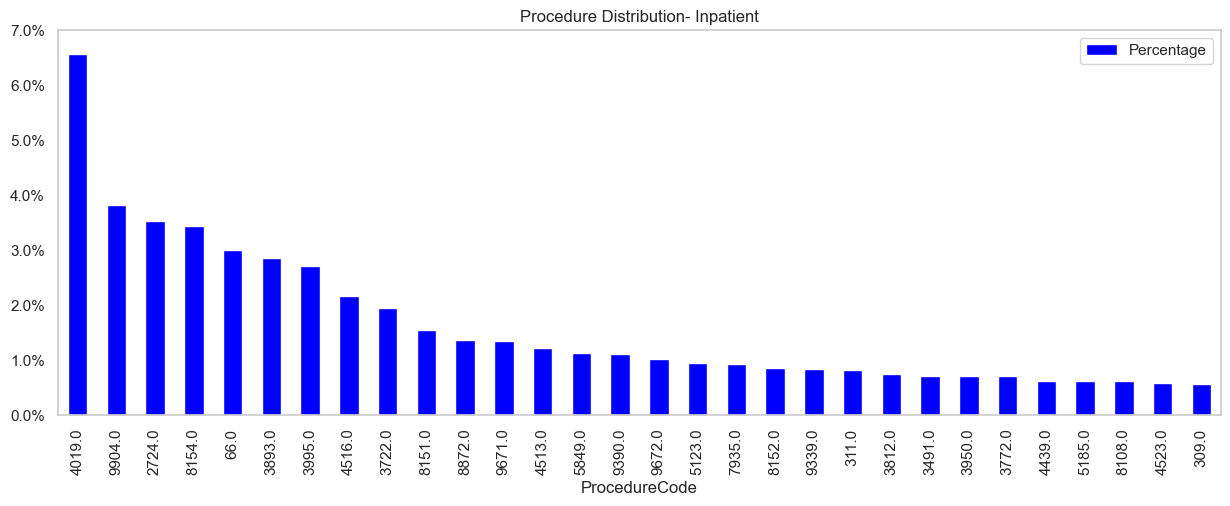

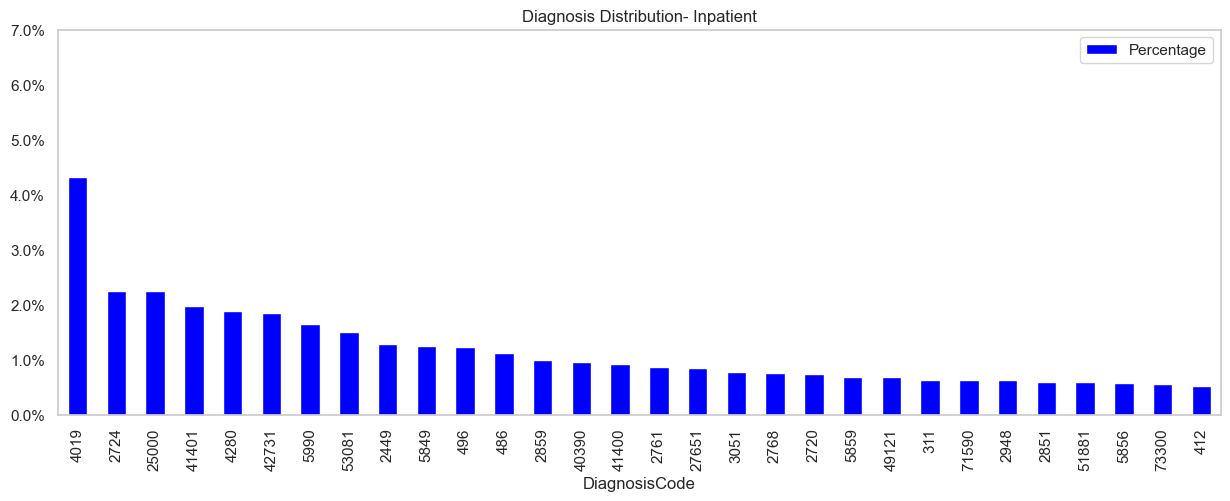

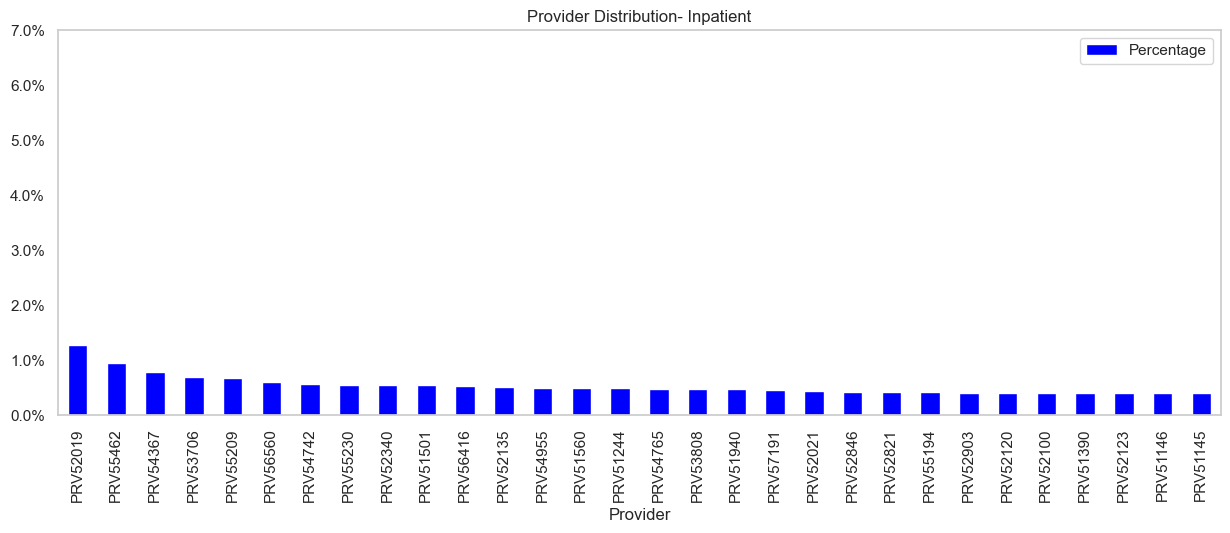

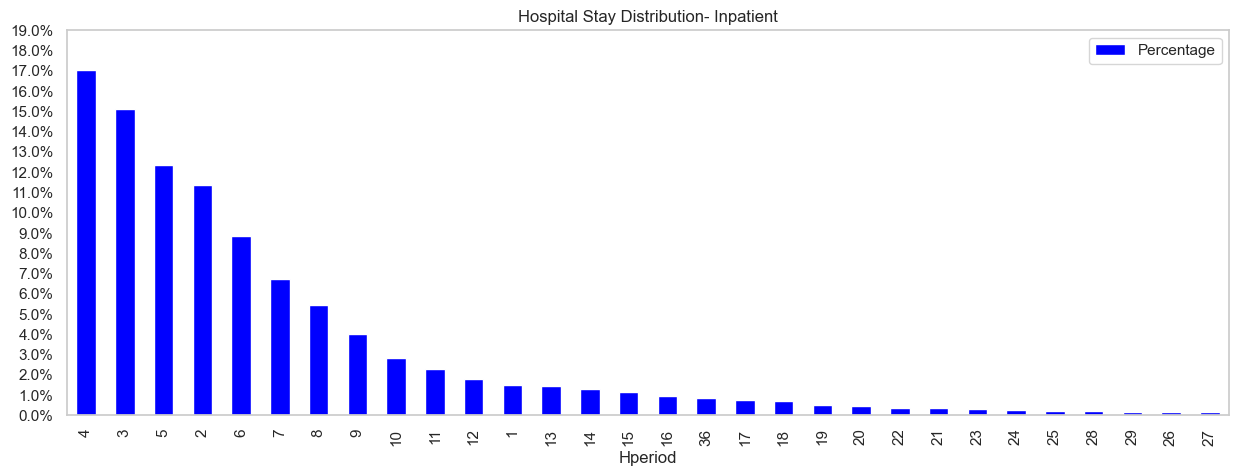

In [233]:
analyse_cat_columns(dataset = inpatient_proc, col_to_analyse='ProcedureCode', title = 'Procedure Distribution- Inpatient')
analyse_cat_columns(dataset = inpatient_dx, col_to_analyse='DiagnosisCode', title = 'Diagnosis Distribution- Inpatient')
analyse_cat_columns(dataset = ip_provider, col_to_analyse='Provider', title = 'Provider Distribution- Inpatient')
analyse_cat_columns(dataset = ip_provider, col_to_analyse='Hperiod', y_lim = np.arange(0,20), title = 'Hospital Stay Distribution- Inpatient')


##### Inpatient - Claim Amount

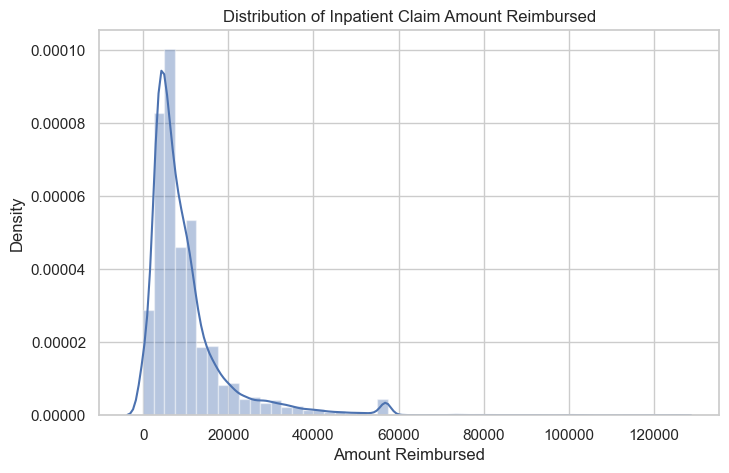

In [234]:
plt.figure(figsize=(8, 5))
sns.distplot(Train_Inpatientdata.InscClaimAmtReimbursed)

# Adding title and labels
plt.title('Distribution of Inpatient Claim Amount Reimbursed')
plt.xlabel('Amount Reimbursed')
plt.ylabel('Density')

# Show plot
plt.show()

##### Conclusions

1. The top procedure is 4019.0. There are 6% patients undergoing this procedure. Based on ICD-9 Code, 4019 is Hypertension NOS (Unspecified essential hypertension).

2. The top diagnosis is also 4019. There are around 4.5% patients diagnosed as Hypertension NOS (Unspecified essential hypertension).

3. In the inpatient claim, providers are evenly distributed. There is no specific providers which submitted more claims than others.

4. More than 90% of paitients stayed in hospital less than 10 days.

5. The distribution of amount reimbursed in the inpatient claim seems like a log normal distribtion. The majority of amount falls between 0 and 20,000.

##### Outpatient - Procedure Code

In [235]:
# figure out the most common procedure code and diagnosis code for outpatient cases
print('outpatient columns:\n',  Train_Outpatientdata.columns)
Train_Outpatientdata.head(5)

outpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [236]:
# create a dataframe for concatinating all Procedure Code columns 
outpatient_proc = pd.DataFrame(columns = ['ProcedureCode'])
outpatient_proc['ProcedureCode'] = pd.concat([Train_Outpatientdata["ClmProcedureCode_1"], 
                                           Train_Outpatientdata["ClmProcedureCode_2"],
                                           Train_Outpatientdata["ClmProcedureCode_3"],
                                           Train_Outpatientdata["ClmProcedureCode_4"], 
                                           Train_Outpatientdata["ClmProcedureCode_5"], 
                                           Train_Outpatientdata["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

print(outpatient_proc.shape)
outpatient_proc.head(5)

(204, 1)


,ProcedureCode
8167,9672.0
9326,4573.0
14740,66.0
30435,66.0
35839,5123.0


In [237]:
# create a dataframe for concatinating all dx Code columns 
outpatient_dx = pd.DataFrame(columns = ['DiagnosisCode'])
outpatient_dx['DiagnosisCode'] = pd.concat([Train_Outpatientdata["ClmDiagnosisCode_1"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_2"],
                                           Train_Outpatientdata["ClmDiagnosisCode_3"],
                                           Train_Outpatientdata["ClmDiagnosisCode_4"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_5"], 
                                           Train_Outpatientdata["ClmDiagnosisCode_6"],
                                           Train_Outpatientdata["ClmDiagnosisCode_7"],
                                           Train_Outpatientdata["ClmDiagnosisCode_8"],
                                           Train_Outpatientdata["ClmDiagnosisCode_9"],
                                           Train_Outpatientdata["ClmDiagnosisCode_10"],], axis=0, sort=True).dropna()

print(outpatient_dx.shape)
outpatient_dx.head(5)

(1353388, 1)


,DiagnosisCode
0,78943
1,6115
2,2723
3,71988
4,82382


In [238]:
# create a dataframe for provider, claim length
op_provider = pd.DataFrame(columns = ['Provider', 'Cperiod'])
op_provider ['Provider'] = Train_Outpatientdata['Provider'].dropna()

startdate = pd.to_datetime(Train_Outpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Outpatientdata.ClaimEndDt)
op_provider ['Cperiod'] = (enddate - startdate).dt.days + 1

print(op_provider.shape)
op_provider.head(5)

(517737, 2)


,Provider,Cperiod
0,PRV56011,1
1,PRV57610,1
2,PRV57595,1
3,PRV56011,1
4,PRV56011,1


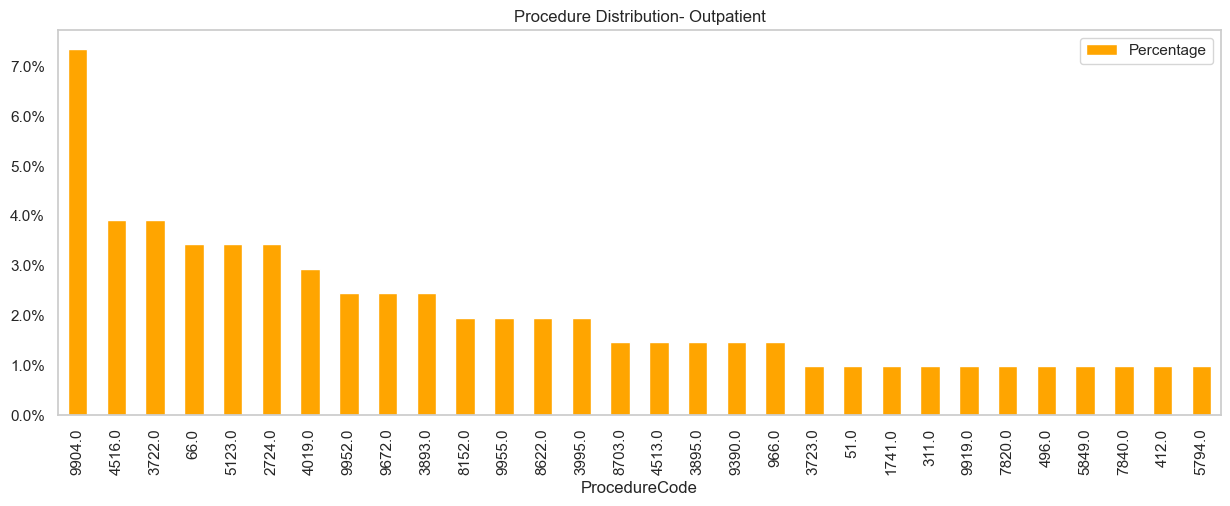

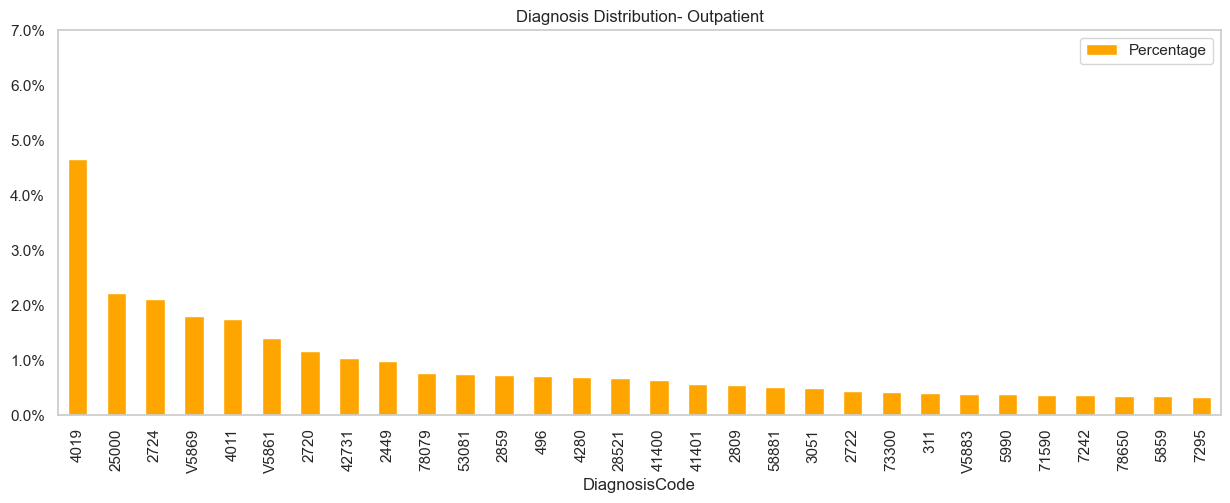

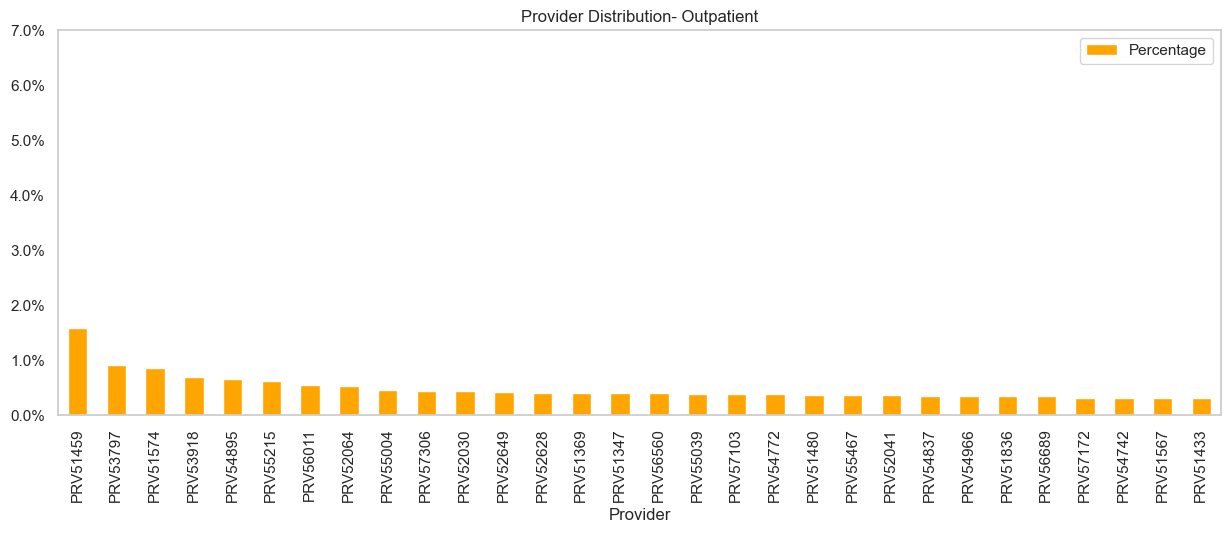

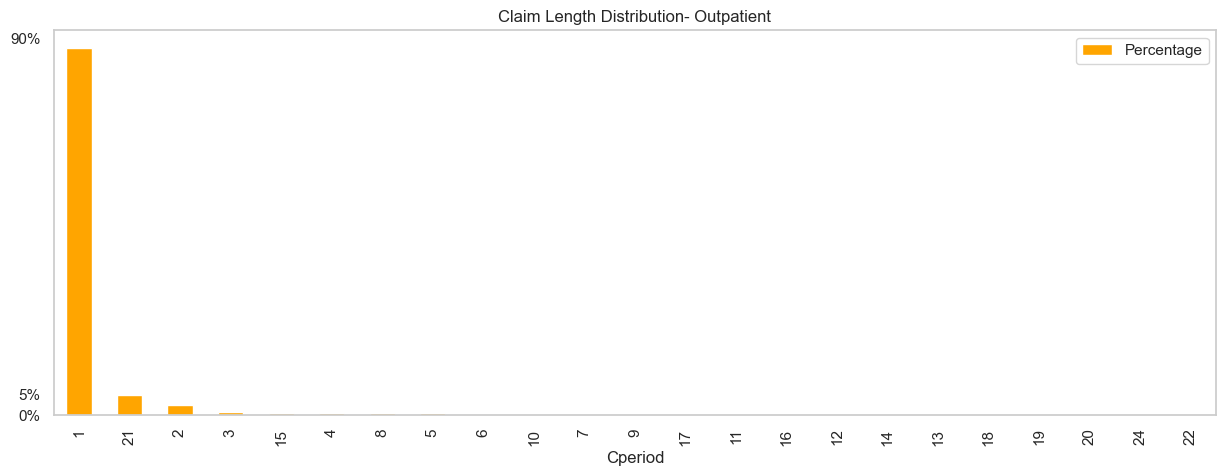

In [239]:
analyse_cat_columns(dataset = outpatient_proc, col_to_analyse='ProcedureCode', title = 'Procedure Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = outpatient_dx, col_to_analyse='DiagnosisCode', title = 'Diagnosis Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = op_provider, col_to_analyse='Provider', title = 'Provider Distribution- Outpatient', color ='orange')
analyse_cat_columns(dataset = op_provider, col_to_analyse='Cperiod', y_lim = (0,90,5), title = 'Claim Length Distribution- Outpatient', color ='orange')


##### Outpatient - Claim Amount

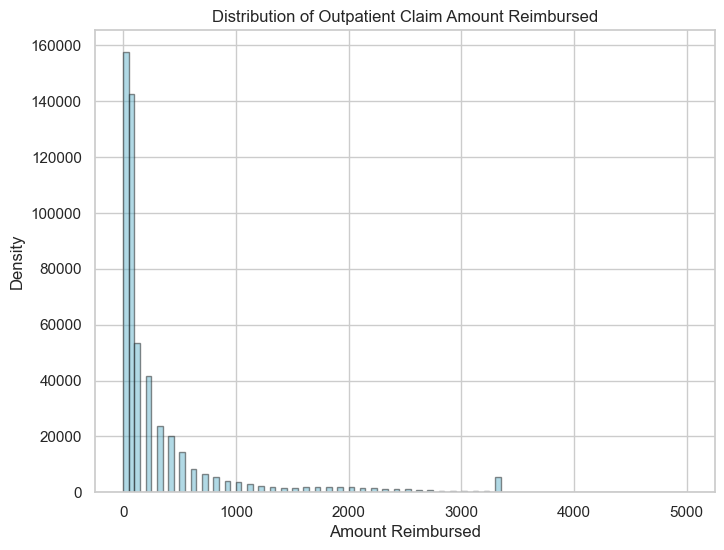

In [240]:
plt.figure(figsize=(8, 5))

Train_Outpatientdata['InscClaimAmtReimbursed'].plot.hist(bins=100,range=[0,5000], alpha=0.5, figsize=(8, 6), facecolor='c', edgecolor='k')

# Adding title and labels
plt.title('Distribution of Outpatient Claim Amount Reimbursed')
plt.xlabel('Amount Reimbursed')
plt.ylabel('Density')

# Show plot
plt.show()

In [241]:
val = np.percentile(Train_Outpatientdata.InscClaimAmtReimbursed,99.9)
val

3500.0

##### Conclusions

The top procedure is 9904.0. There are around 7.3% patients undergoing this procedure. Based on ICD-9 Code, 9904 is Transfusion Of Packed Cells. 4516 is the second popular procedure, which is Esophagogastroduodenoscopy [Egd] With Closed Biopsy.

The top diagnosis is the same as the inpatient's data -  4019. There are around 4.5% patients diagnosed as Hypertension NOS (Unspecified essential hypertension). The second dx code 25000 is Incision Procedures on the Forearm and Wrist.

Provider 'PRV51459' has around 1% more claims than other providers.

The majority of claim length is 1 day.

The claim reimbursed amount in outpaitent claims shows a rough log normal distribution. However, on the tail, there is a signal of outliers around $3500.

#### Data preprocessing

##### Merging OutPatient ,Inpatient and Beneficiary to get the whole dataset


In [242]:
Train_Inpatientdata['is_admitted'] = 1
Train_Outpatientdata['is_admitted'] = 0

In [243]:
Train_Allpatientdata = pd.merge(Train_Outpatientdata, Train_Inpatientdata, how='outer')
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on = 'BeneID', how = 'inner')

In [244]:
# add labels
df = pd.merge(Train_Allpatientdata, Train, on = 'Provider')

In [245]:
print(df.shape)
df.head(5)

(558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,2,2,2,2,2,0,0,30,50,Yes
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,1,1,1,1,2,0,0,1810,760,Yes
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,1,1,1,1,2,0,0,1810,760,Yes
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,20381,...,1,1,1,1,2,0,0,1810,760,Yes
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,V6546,...,1,1,1,1,2,0,0,1810,760,Yes


In [246]:
# Train_Beneficiarydata.RenalDiseaseIndicator.unique()#array(['0', 'Y'], dtype=object)
# Replace values with a binary annotation
df = df.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})#array([0, 1], dtype=int64)

In [247]:
# Replace values with a binary annotation (1,2 to 0,1)
df = df.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'Gender': 2 }, 
                  0)

In [248]:
# 1 representing potential fraud and 0 representing non potential fraud
df['PotentialFraud'] = df['PotentialFraud'].map({"Yes":1,"No":0})#.astype('category',copy=False)
df['PotentialFraud'].dtype

dtype('int64')

PotentialFraud
0    345415
1    212796
Name: count, dtype: int64


<Axes: xlabel='PotentialFraud', ylabel='count'>

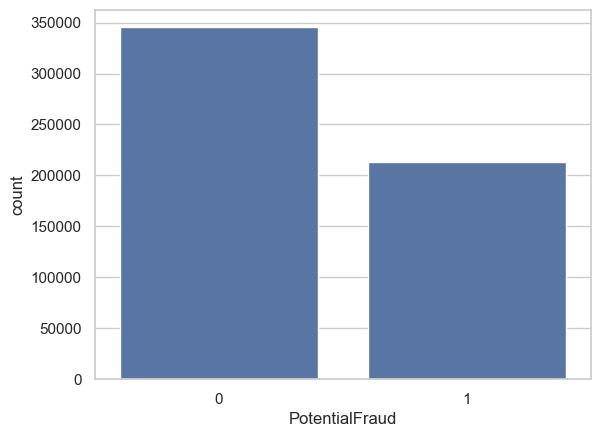

In [249]:
# check labels
print(df.PotentialFraud.value_counts())
sns.countplot(x='PotentialFraud', data=df)
# The dataset is imbalanced.

In [250]:
#show null values amount
print('null value amount:\n', df.isna().sum())

#show null values percentage
print('null value percentage:\n', df.isnull().mean()*100)

#figure out high percentage columns
nullPercent = df.isnull().mean()*100
filtered_columns = nullPercent[nullPercent > 70].index
print(filtered_columns)



null value amount:
 BeneID                                  0
ClaimID                                 0
ClaimStartDt                            0
ClaimEndDt                              0
Provider                                0
InscClaimAmtReimbursed                  0
AttendingPhysician                   1508
OperatingPhysician                 443764
OtherPhysician                     358475
ClmDiagnosisCode_1                  10453
ClmDiagnosisCode_2                 195606
ClmDiagnosisCode_3                 315156
ClmDiagnosisCode_4                 393675
ClmDiagnosisCode_5                 446287
ClmDiagnosisCode_6                 473819
ClmDiagnosisCode_7                 492034
ClmDiagnosisCode_8                 504767
ClmDiagnosisCode_9                 516396
ClmDiagnosisCode_10                553201
ClmProcedureCode_1                 534901
ClmProcedureCode_2                 552721
ClmProcedureCode_3                 557242
ClmProcedureCode_4                 558093
ClmProcedureCo

###### check duplicates

In [251]:
#Checking how many distinct BeneID we have in our data
print(len(list(df.BeneID.value_counts()==1)))
print(len(list(df['BeneID'].unique())))

138556
138556


In [252]:
#Checking how many distinct BeneID we have in our data
print(len(list(df.ClaimID.value_counts()==1)))
print(len(list(df['ClaimID'].unique())))

558211
558211


Conclusion:

1. Each BeneID can have multiple claims which will have seperate record (different claim_id).
2. No duplicates in our dataset.

##### Feature Engineering


###### Feature creation

In [253]:
#Adding a column is_dead  = 1  DOD is given else is_dead = 0 
df['Is_Dead'] = np.where(df['DOD'].isnull(), 0, 1)

In [254]:
#Add column age
# Convert 'DOB' and 'ClaimStartDt' columns to datetime format
df['DOB'] =  pd.to_datetime(df['DOB'], format='%Y-%m-%d')  
df['ClaimStartDt'] = pd.to_datetime(df['ClaimStartDt'], format='%Y-%m-%d')  
df['Age'] = (df['ClaimStartDt'] - df['DOB']).dt.days // 365


In [255]:
#calculate number of hospital stays
#outpatients don't get admitted so we keep 0 for them
df['AdmissionDt'] = pd.to_datetime(df['AdmissionDt'] , format = '%Y-%m-%d')
df['DischargeDt'] = pd.to_datetime(df['DischargeDt'],format = '%Y-%m-%d')
df['Hperiod'] = ((df['DischargeDt'] - df['AdmissionDt']).dt.days)+1
df.loc[df['is_admitted'] == 0, 'Hperiod'] = 0



In [256]:
# calculate the period of claims
startdate = pd.to_datetime(df.ClaimStartDt)
enddate = pd.to_datetime(df.ClaimEndDt)
df['Cperiod'] = (enddate - startdate).dt.days+1

In [257]:
#check for same physician in all three physician columns
def physician_same(row):
    atten_oper = row['AttendingPhysician'] == row['OperatingPhysician']
    oper_other = row['OperatingPhysician'] == row['OtherPhysician']
    atten_other = row['AttendingPhysician'] == row['OtherPhysician']
    
    # atten = oper = other
    if atten_oper == True and oper_other == True:
        return 0
    
    # atten = oper != other
    elif atten_oper == True and oper_other == False:
        return 1
    
    # atten = other != oper
    elif atten_other == True and oper_other == False:
        return 2
    
    # atten != other = oper
    elif atten_other == False and oper_other == True:
        return 3
    
    # atten != other != oper
    else:
        return 4


df['phy_same'] = df.apply(physician_same, axis=1)

In [258]:
# # count unique physicians in each claim
# def N_unique_values(df):
#     """This function finds the unique values in a df row"""
#     return np.array([len(set([i for i in x[~pd.isnull(x)]])) for x in df.values])

# df['N_unique_Physicians'] = N_unique_values(df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']]) 

In [259]:
# count how many dx and proc a claim has
Diag_proce_col = ['ClmAdmitDiagnosisCode', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_10',
                  'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                  'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
                  'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmProcedureCode_1',
                  'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
                  'ClmProcedureCode_5', 'ClmProcedureCode_6']

for i in Diag_proce_col:
    df[i][df[i]!=0]= 1

df[Diag_proce_col]= df[Diag_proce_col].astype(float)


df[Diag_proce_col].head(5)

,ClmAdmitDiagnosisCode,ClmDiagnosisCode_1,ClmDiagnosisCode_10,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [260]:
#adding column total_num_diag
df['total_num_diag'] = 0 
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

for col in diagnosis_col :
    df['total_num_diag']  +=  df[col]

In [261]:
#adding column total_num_proce
df['total_num_proce'] = 0 
procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']

for col in procedure_col :
    df['total_num_proce']  = df['total_num_proce'] + df[col]

In [262]:
df['total_num_diag'] =  df['total_num_diag'].astype(float)
df['total_num_proce'] =  df['total_num_proce'].astype(float)

In [263]:
# Group by 'BeneID' and calculate total amount and count of claims
grouped = df.groupby('BeneID')['InscClaimAmtReimbursed'].agg(['sum', 'count'])

# Calculate mean amount for each 'BeneID'
grouped['mean'] = grouped['sum'] / grouped['count']

# Merge with df to get 'BeneID' and corresponding statistics
df = df.merge(grouped, left_on='BeneID', right_index=True, how='left')

print("Dataset shape : ", df.shape)
df.head(5)



Dataset shape :  (558211, 66)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Is_Dead,Age,Hperiod,Cperiod,phy_same,total_num_diag,total_num_proce,sum,count,mean
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,1.0,...,0,73,0.0,1,4,10.0,6.0,30,1,30.000000
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333


###### deal with null values

In [264]:
# replace null values with 0
df.loc[df['DeductibleAmtPaid'].isnull(), 'DeductibleAmtPaid'] = 0
df[Diag_proce_col]= df[Diag_proce_col].replace({np.nan:0})
df['DiagnosisGroupCode']= df['DiagnosisGroupCode'].replace({np.nan:0})

df.head(5)

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,Is_Dead,Age,Hperiod,Cperiod,phy_same,total_num_diag,total_num_proce,sum,count,mean
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,1.0,...,0,73,0.0,1,4,10.0,6.0,30,1,30.000000
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,1.0,...,0,86,0.0,1,4,10.0,6.0,1810,12,150.833333


###### Encoding

<Axes: title={'center': 'Top 5 sucpicious Diagnosis'}, xlabel='DiagnosisCode'>

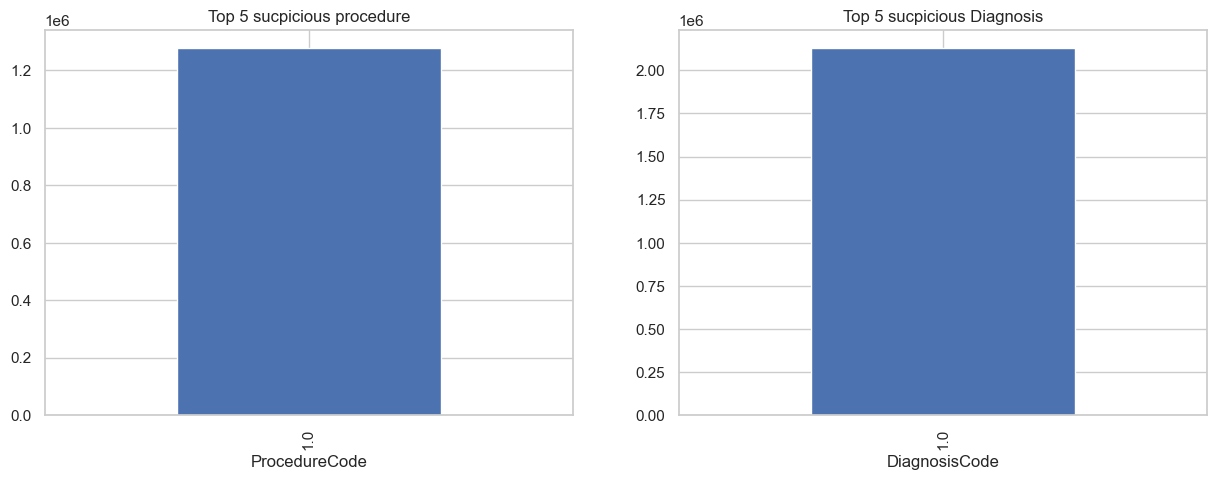

In [265]:
# encode procedure code and dx code
potential_fraud_df =df.loc[df['PotentialFraud'] == 1]

df1 = pd.DataFrame(columns = ['ProcedureCode'])
df1['ProcedureCode'] = pd.concat([potential_fraud_df["ClmProcedureCode_1"], 
                                           potential_fraud_df["ClmProcedureCode_2"],
                                           potential_fraud_df["ClmProcedureCode_3"],
                                           potential_fraud_df["ClmProcedureCode_4"], 
                                           potential_fraud_df["ClmProcedureCode_5"], 
                                           potential_fraud_df["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

df2 = pd.DataFrame(columns = ['DiagnosisCode'])
df2['DiagnosisCode'] = pd.concat([potential_fraud_df["ClmDiagnosisCode_1"], 
                                           potential_fraud_df["ClmDiagnosisCode_2"], 
                                           potential_fraud_df["ClmDiagnosisCode_3"], 
                                           potential_fraud_df["ClmDiagnosisCode_4"],
                                           potential_fraud_df["ClmDiagnosisCode_5"], 
                                           potential_fraud_df["ClmDiagnosisCode_6"],
                                           potential_fraud_df["ClmDiagnosisCode_7"],
                                           potential_fraud_df["ClmDiagnosisCode_8"],
                                           potential_fraud_df["ClmDiagnosisCode_9"],
                                           potential_fraud_df["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()
plt.figure(figsize=(15, 5))
plt.subplot(121)
df1.ProcedureCode.value_counts().head(5).plot(kind = 'bar' , title ='Top 5 sucpicious procedure')

plt.subplot(122)
df2.DiagnosisCode.value_counts().head(5).plot(kind = 'bar' , title ='Top 5 sucpicious Diagnosis')

In [266]:
# method 1: apply one-hot encoding on all proc code and dx code(don't consider the seq)

procedure_col = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']

# Step 1: Extract procedure codes from specified columns
procedure_codes = df[procedure_col]

# Step 2: Concatenate the procedure codes into a single DataFrame
procedure_codes_concat = pd.concat([procedure_codes[col] for col in procedure_col], axis=0, ignore_index=True)

# Step 3: One-hot encode the procedure codes
procedure_codes_encoded = pd.get_dummies(procedure_codes_concat, prefix='Procedure')
procedure_codes_encoded

# It will cause sparse data.

,Procedure_1.0
0,True
1,True
2,True
3,True
4,True
...,...
3349261,True
3349262,True
3349263,True
3349264,True


In [267]:
# method 2: encode top 5 proc code and dx code only
def encoded_cat(dataset, feature_to_encode='',col_list=[]):
    """This function returns top 5 cat column useful in determining potential fraud"""
    outer_list =[]
    for col in col_list:
        list_1 = list()
        
        for item in list(dataset[col]):
            if str(item) == str(feature_to_encode):
                list_1.append(1)
            else:
                list_1.append(0)
        
        outer_list.append(list_1)
    
    li_sum = np.array([0]*558211)
    
    for i in range(0,len(outer_list)):
        li1 = np.array(outer_list[i])
        li_sum = li_sum + li1
        
    return li_sum


#encode top 5 procedure
# 4019.0, 2724.0, 9904.0, 8154.0, 66.0
df['pr_4019'] = encoded_cat(df,'4019.0',procedure_col)
df['pr_2724'] = encoded_cat(df,'2724.0',procedure_col)
df['pr_9904'] = encoded_cat(df,'9904.0',procedure_col)
df['pr_8154'] = encoded_cat(df,'8154.0',procedure_col)
df['pr_66'] =   encoded_cat(df,'66.0',procedure_col)

#encode top 5 diagnosis 
#4019,25000,2724,V5869,42731
df['di_4019'] = encoded_cat(df,'4019',diagnosis_col)
df['di_25000'] = encoded_cat(df,'25000',diagnosis_col)
df['di_2724'] = encoded_cat(df,'2724',diagnosis_col)
df['di_V5869'] = encoded_cat(df,'V5869',diagnosis_col)
df['di_42731'] =   encoded_cat(df,'42731',diagnosis_col)

df

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,pr_4019,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
1,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
2,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
3,BENE11004,CLM173224,2009-02-03,2009-02-03,PRV56011,20,PHY339887,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
4,BENE11004,CLM224741,2009-03-03,2009-03-03,PRV56011,40,PHY345721,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558206,BENE57978,CLM37910,2009-02-11,2009-02-16,PRV53511,0,PHY378514,PHY426843,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
558207,BENE80245,CLM79653,2009-12-15,2009-12-18,PRV51711,4000,PHY345109,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
558208,BENE85177,CLM77745,2009-11-29,2009-12-07,PRV54503,8000,PHY418343,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0
558209,BENE105577,CLM53155,2009-05-28,2009-05-31,PRV51239,5000,PHY382916,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,0,0


In [268]:
#encoding types of physicians into numeric values
df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(df[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
df['N_Types_Physicians'] = df['AttendingPhysician'] +  df['OperatingPhysician'] + df['OtherPhysician']


In [269]:
#final check to see if a col val is NaN
col_inf_df=pd.DataFrame() 
val = df.isnull().sum()
col_inf_df['null_col_count']  = val
col_inf_df['column'] = val.index
col_inf_df.loc[col_inf_df['null_col_count'] !=0]

,null_col_count,column
AdmissionDt,517737,AdmissionDt
DischargeDt,517737,DischargeDt
DOD,554080,DOD


###### Feature deletion

In [270]:
# Drop irrelevant columns
col_to_remove = ['Provider','BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AdmissionDt', 'DischargeDt', 'DOB', 'DOD','AttendingPhysician',\
                 'OperatingPhysician', 'OtherPhysician','ClmAdmitDiagnosisCode','NoOfMonths_PartACov',\
                 'NoOfMonths_PartBCov','DiagnosisGroupCode']

df.drop(columns=col_to_remove, axis=1, inplace=True)
df['PotentialFraud']=df['PotentialFraud'].astype(int)

df.head()


,InscClaimAmtReimbursed,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,...,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,N_Types_Physicians
0,30,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1,40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,200,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,20,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
4,40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1


In [271]:
df['PotentialFraud'].value_counts()


PotentialFraud
0    345415
1    212796
Name: count, dtype: int64

In [272]:
y = df['PotentialFraud']
X = df.drop('PotentialFraud', axis=1)

In [273]:
X.columns

Index(['InscClaimAmtReimbursed', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'is_admitted', 'Gender', 'Race', 'RenalDiseaseIndicator', 'State',
       'County', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'Is_Dead', 'Ag

<Axes: >

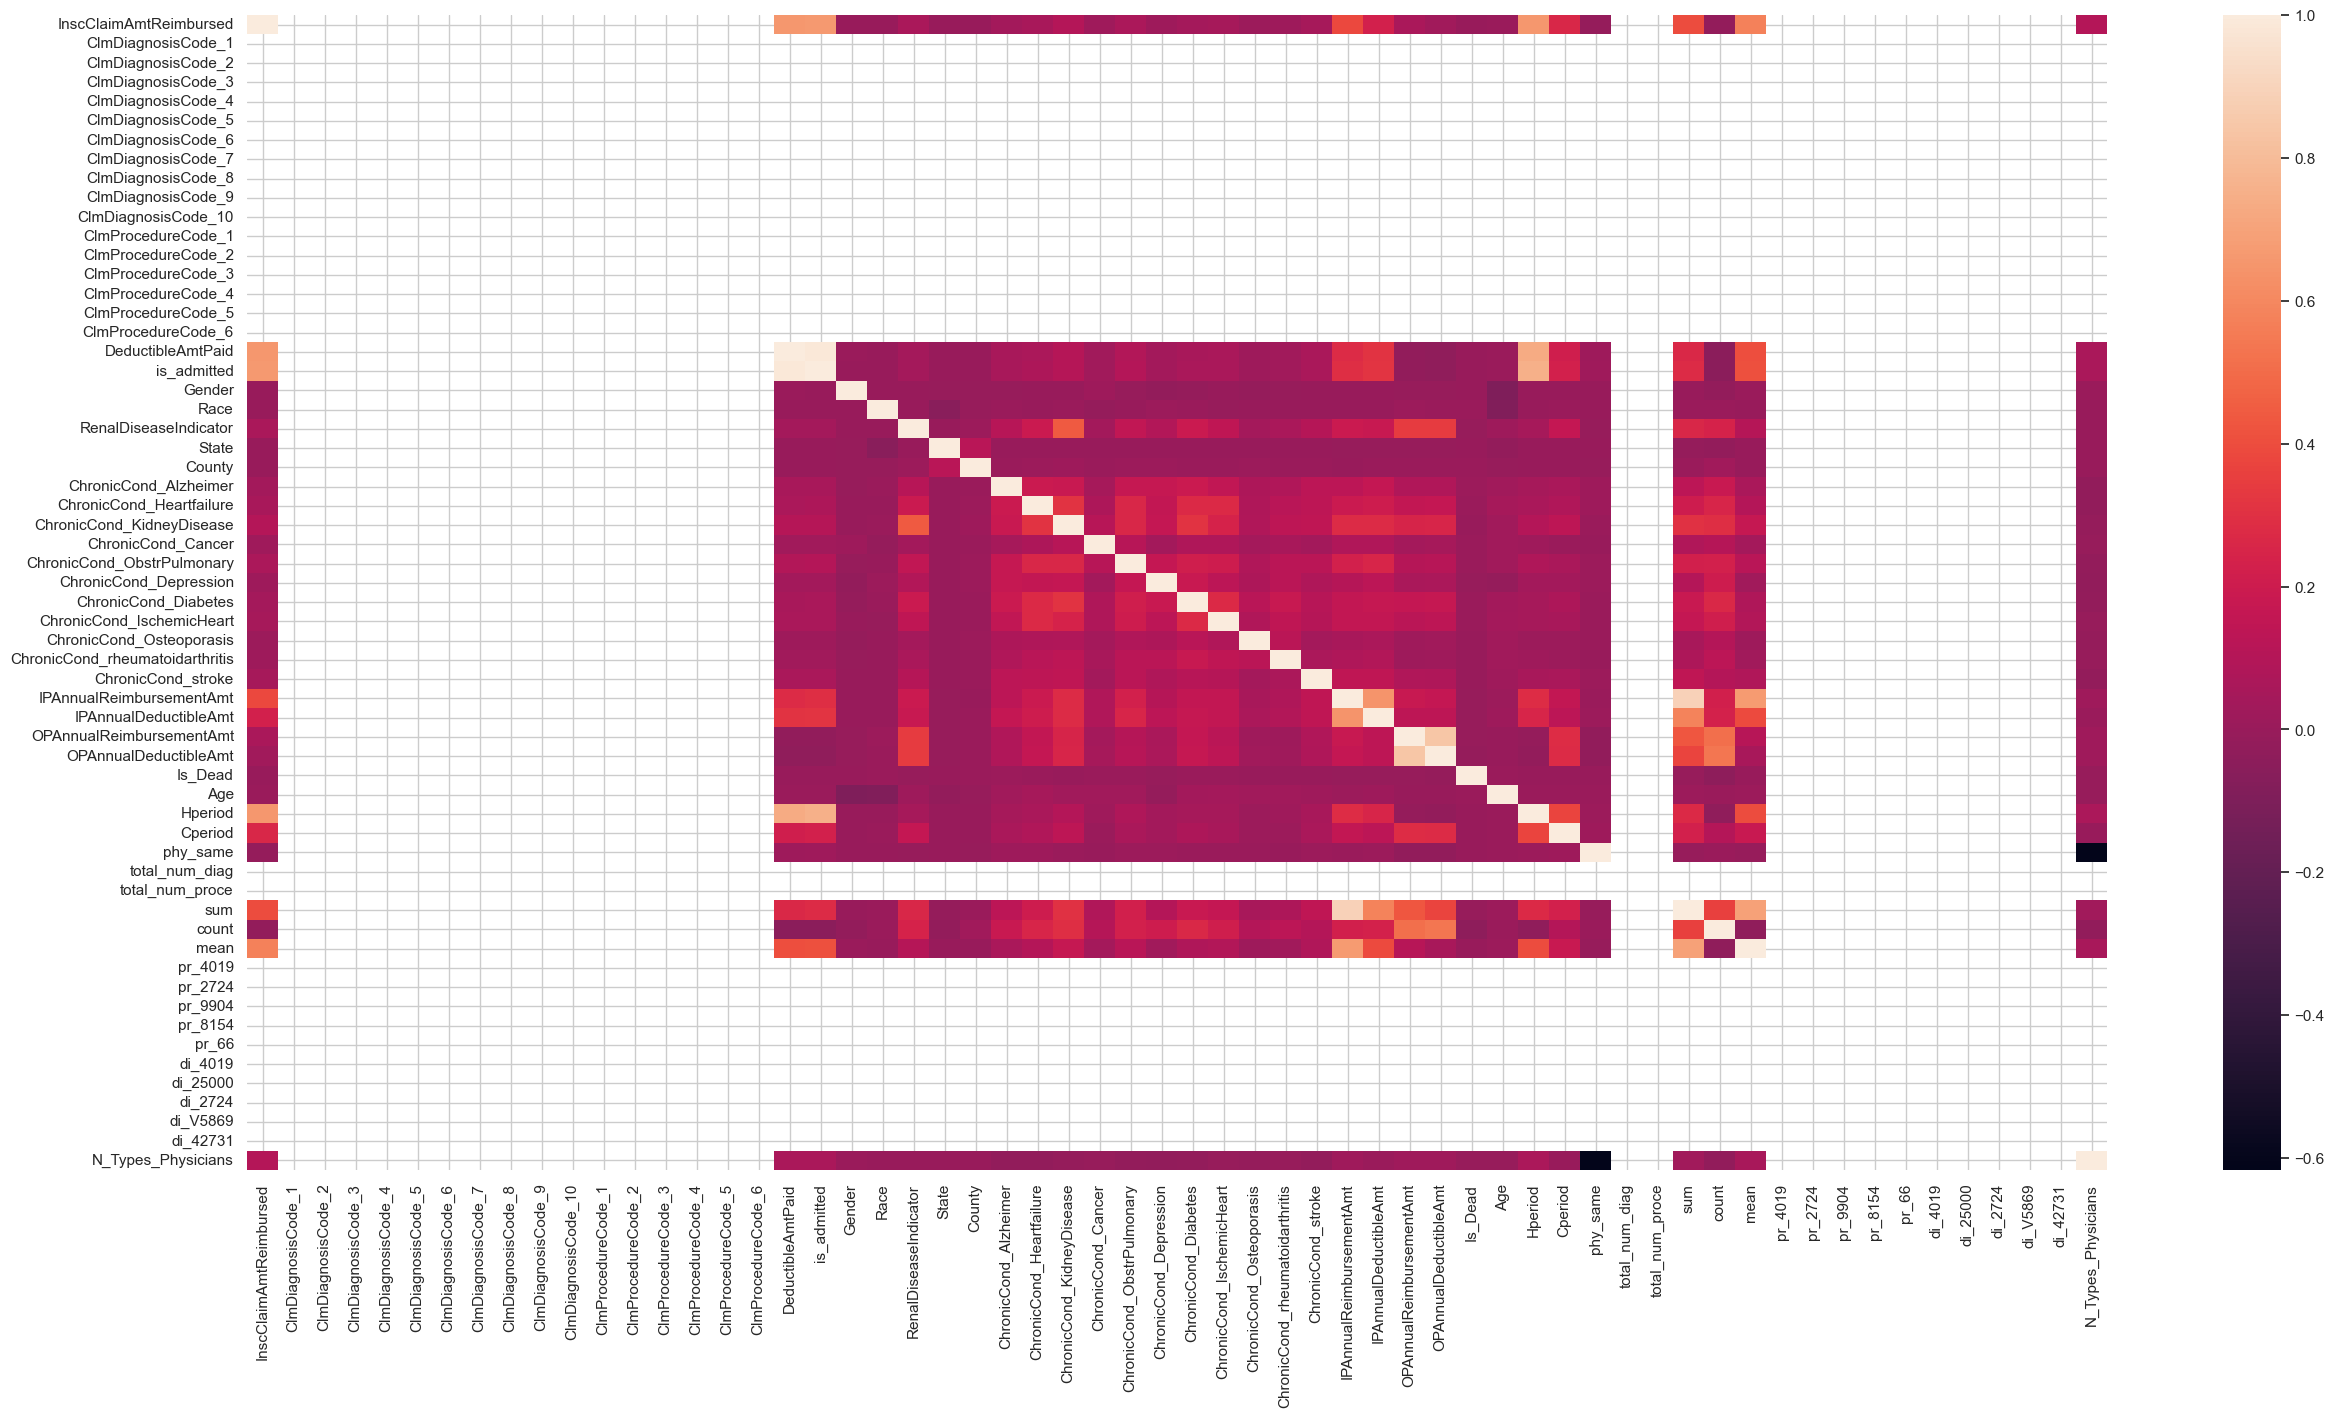

In [274]:
#plot correlation heat map between features
sns.set(context='notebook', style='whitegrid')
plt.figure(figsize=(30, 15))
corr = X.corr()
sns.heatmap(corr, annot=False)

In [275]:
# split data into train, validation, test dataset
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

print("Training X : ",X_train.shape," | Training Y : ",y_train.shape)
print("Training X : ",X_val.shape," | Training Y : ",y_val.shape)
print("Test X : ",X_test.shape," | Test Y : ",y_test.shape)

Training X :  (334926, 60)  | Training Y :  (334926,)
Training X :  (111642, 60)  | Training Y :  (111642,)
Test X :  (111643, 60)  | Test Y :  (111643,)


###### Normalization - Handling Numerical Column

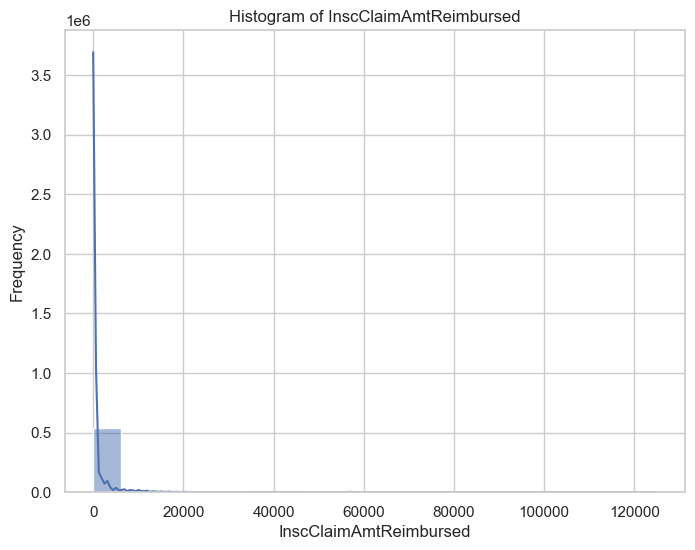

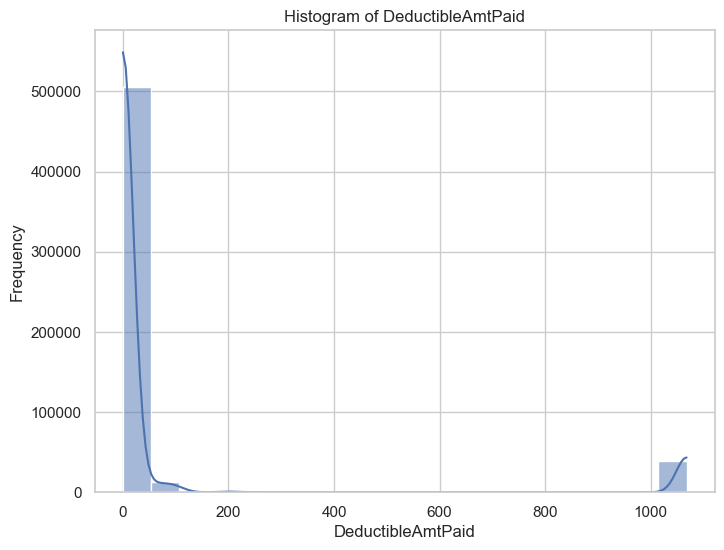

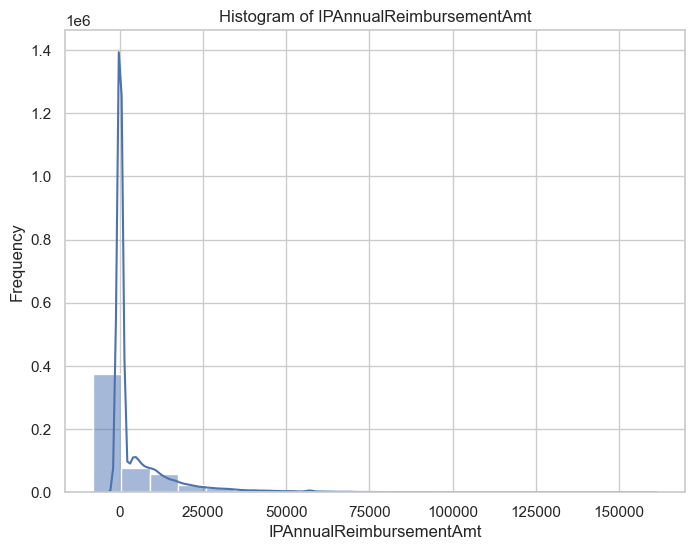

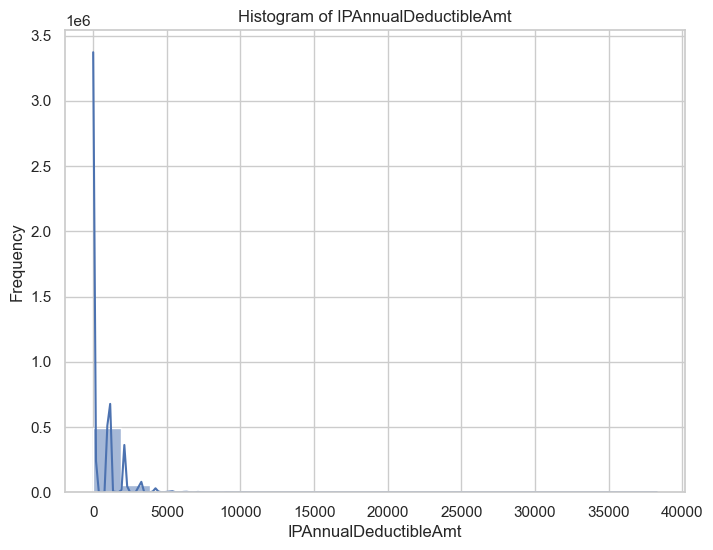

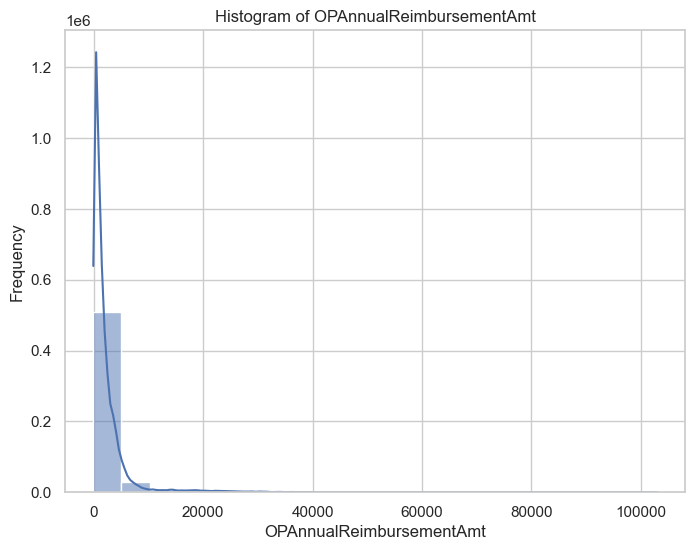

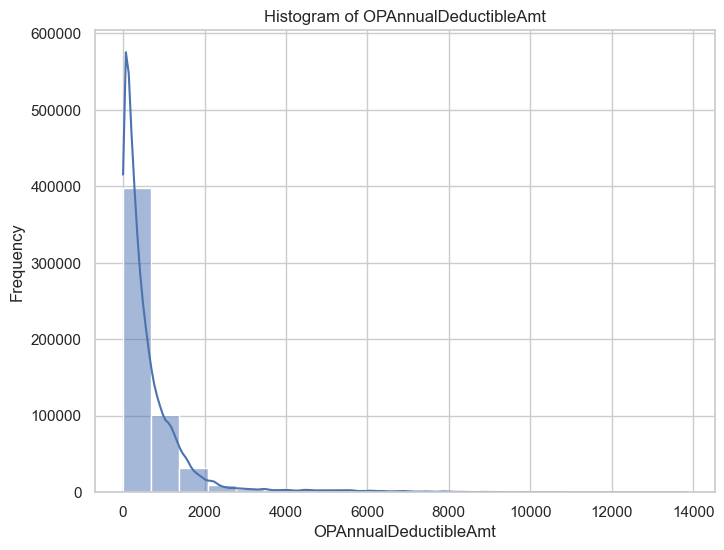

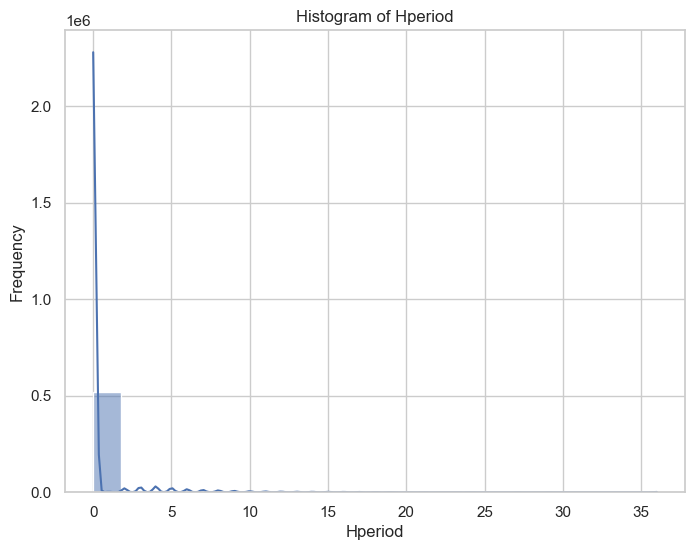

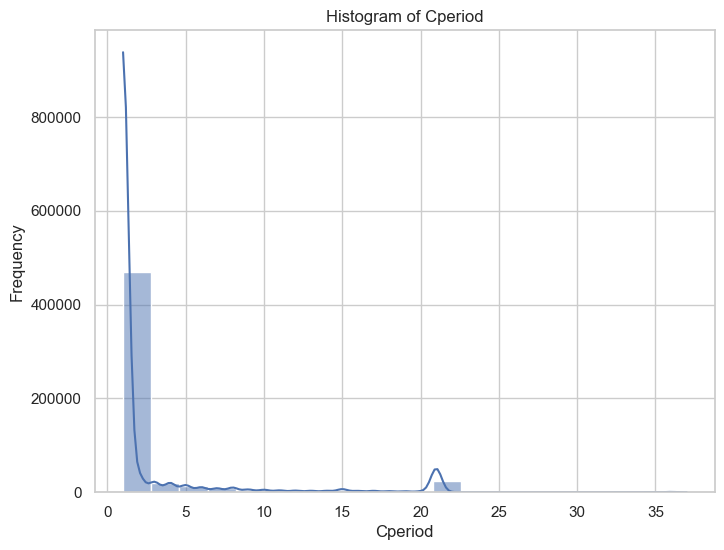

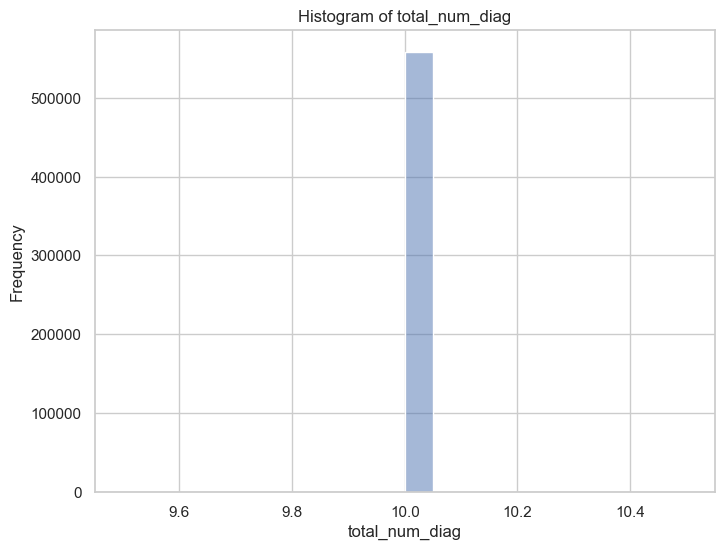

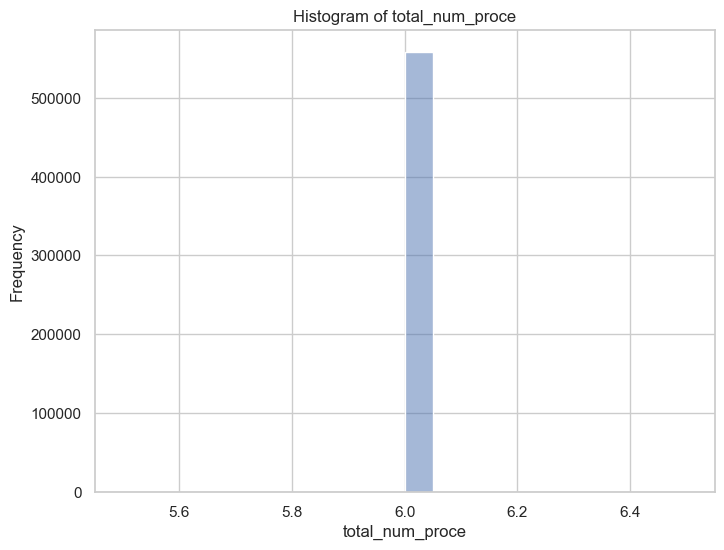

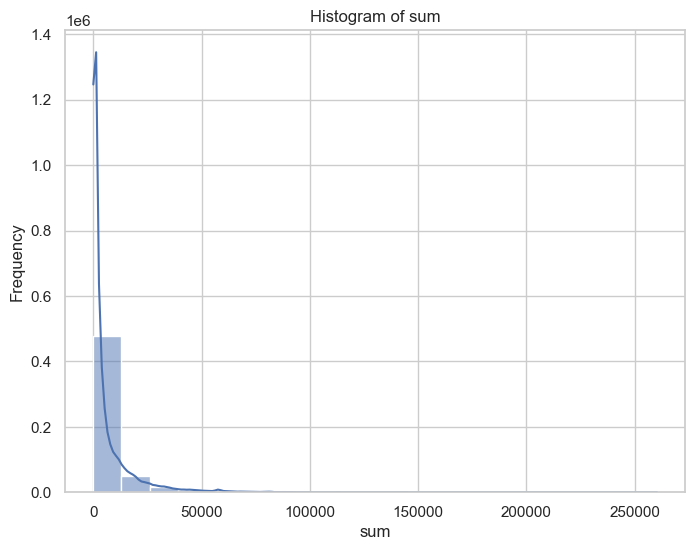

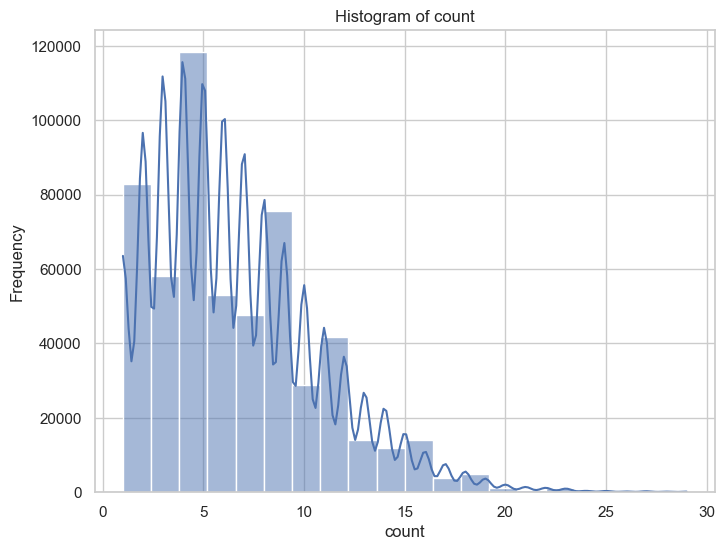

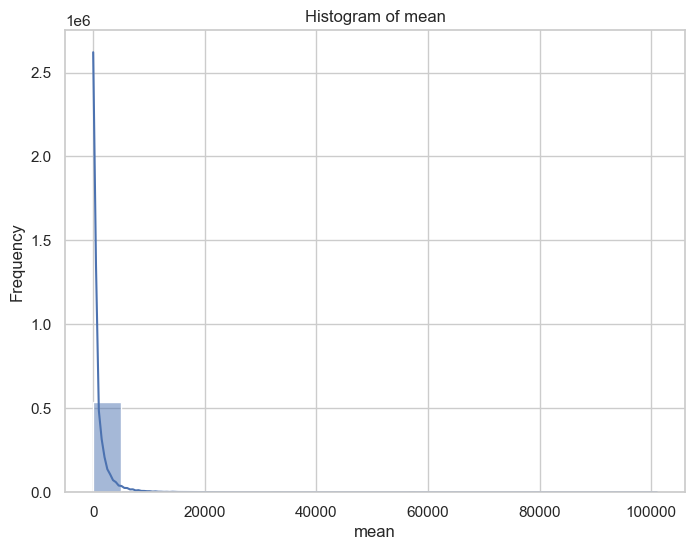

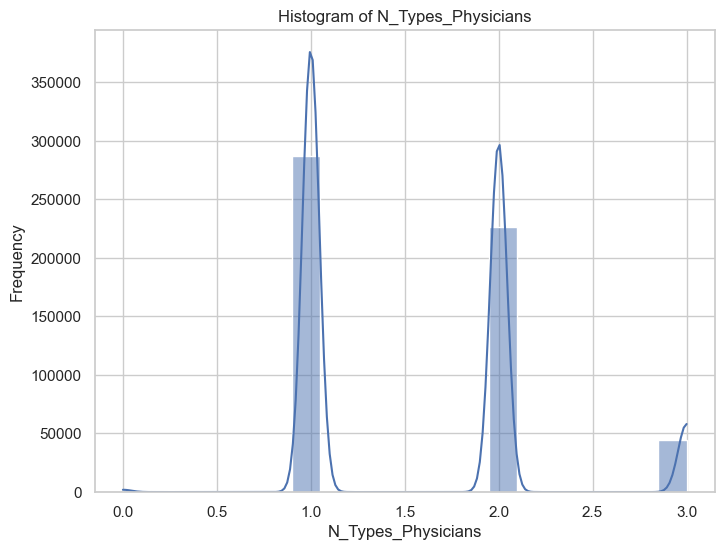

In [276]:
# Columns to normalize
columns_to_normalize = [
    'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt',  'Hperiod', 'Cperiod',
       'total_num_diag', 'total_num_proce',
       'sum', 'count', 'mean', 
       'N_Types_Physicians'
]

# Plot histograms for each numerical column
for column in columns_to_normalize:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True, bins=20)  # Adjust bins as needed
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

In [277]:
# calculates and stores the parameters necessary for normalization based on the training data.
def num_col_normalizer(X_tr,X_va,X_te,col=''):
    """This function returns normalized column for train, validation, and test data"""
    normalizer = Normalizer()
    
    normalizer.fit(X_tr[col].values.reshape(-1,1))
    
    tr = normalizer.transform(X_tr[col].values.reshape(-1,1))
    va = normalizer.transform(X_va[col].values.reshape(-1,1))
    te = normalizer.transform(X_te[col].values.reshape(-1,1))
    
    return tr,va,te


# Normalize each column in train and test data
for col in tqdm_notebook(columns_to_normalize):
    tr, va, te = num_col_normalizer(X_train, X_val, X_test, col)
    X_train[col] = tr
    X_val[col] = va
    X_test[col] = te


  0%|          | 0/14 [00:00<?, ?it/s]

###### Use both ENN and SMOTE

In [100]:
print("Before preprocessing, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before preprocessing, counts of label '0': {} \n".format(sum(y_train == 0))) 
  

from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

enn = EditedNearestNeighbours() 
X_train, y_train = enn.fit_resample(X_train, y_train.ravel()) 
  
print('After UnderSampling, the shape of train_X: {}'.format(X_train.shape)) 
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train.shape)) 
  
print("After UnderSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("After UnderSampling, counts of label '0': {}".format(sum(y_train == 0)))

smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before preprocessing, counts of label '1': 127507
Before preprocessing, counts of label '0': 207419 

After UnderSampling, the shape of train_X: (238122, 61)
After UnderSampling, the shape of train_y: (238122,) 

After UnderSampling, counts of label '1': 127507
After UnderSampling, counts of label '0': 110615
After OverSampling, the shape of train_X: (255014, 61)
After OverSampling, the shape of train_y: (255014,) 

After OverSampling, counts of label '1': 127507
After OverSampling, counts of label '0': 127507


In [101]:
X_train.head(5)


,InscClaimAmtReimbursed,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,...,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,N_Types_Physicians
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0


In [102]:
X_test.head(5)


,InscClaimAmtReimbursed,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,...,pr_2724,pr_9904,pr_8154,pr_66,di_4019,di_25000,di_2724,di_V5869,di_42731,N_Types_Physicians
230744,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
27826,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
314625,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
140256,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
502955,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0


#### EDA

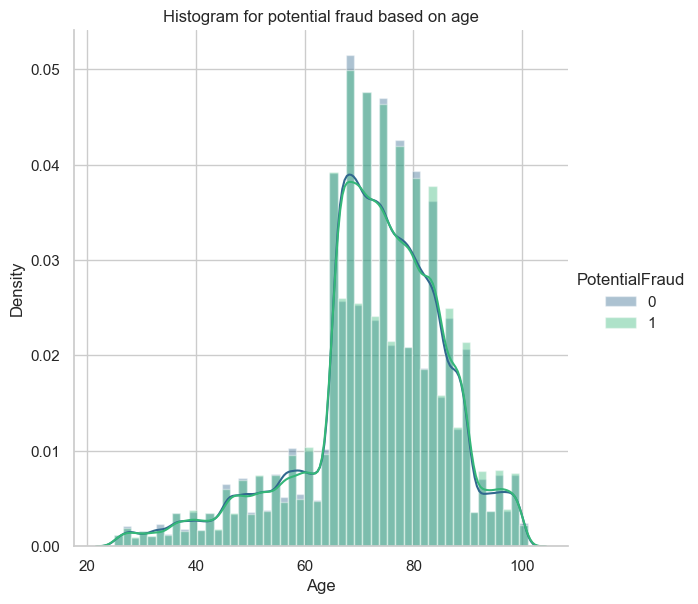

<Figure size 640x480 with 0 Axes>

In [103]:
# sns.distplot(df['Age'])
# plt.title('Histogram for Age')
#plotting age
sns.FacetGrid(df, hue="PotentialFraud" , height=6, palette='viridis').map(sns.distplot, "Age",).add_legend()
plt.title('Histogram for potential fraud based on age')
plt.show()
plt.tight_layout()

##### Age:

While there is no significant difference in the age distribution that would allow us to flag potential fraud, we do observe an increasing trend in potential fraud cases among patients aged 65 and older. Additionally, most patients who apply for claims fall within this age range.

Text(0.5, 1.0, 'Plot to Analyse relation between Race and fraud/not fraud')

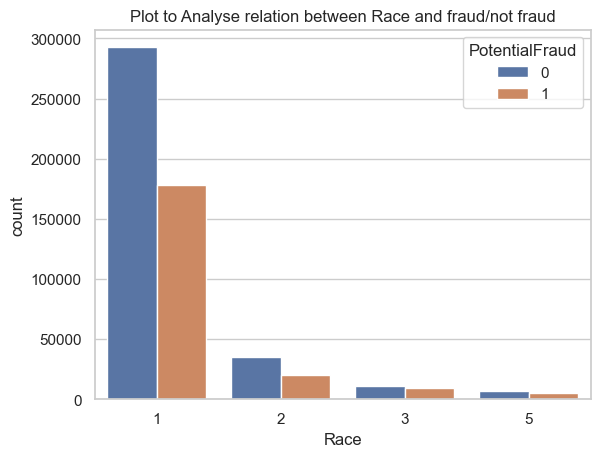

In [104]:
ax = sns.countplot(x='Race',data=df,hue='PotentialFraud')
ax.set_title("Plot to Analyse relation between Race and fraud/not fraud")

##### Race:

A significant number of fraudulent cases involve patients belonging to a specific race, labeled as 1.

In [105]:
# deal with dx code and proc code
# Applying coalesce function to dx columns 
# filling dx_1 by other dx columns  
df['ClmDiagnosisCode_1'] = df[[f'ClmDiagnosisCode_{i}' for i in range(1, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_1']
df['ClmDiagnosisCode_2'] = df[[f'ClmDiagnosisCode_{i}' for i in range(2, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_2']
df['ClmDiagnosisCode_3'] = df[[f'ClmDiagnosisCode_{i}' for i in range(3, 11)]].fillna(method='ffill', axis=1)['ClmDiagnosisCode_3']


# Applying coalesce function to proc columns 
df['ClmProcedureCode_1'] = df[[f'ClmProcedureCode_{i}' for i in range(1, 7)]].fillna(method='ffill', axis=1)['ClmProcedureCode_1']
df['ClmProcedureCode_2'] = df[[f'ClmProcedureCode_{i}' for i in range(2, 7)]].fillna(method='ffill', axis=1)['ClmProcedureCode_2']



#### Modeling

##### Utility Functions


In [106]:
def get_threshould_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()

#determining best threshold
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

#pridicting Yq for given Xq with best threshold:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)

    print(classification_report(y, predict_with_best_t(y_pred, best_t))) 


In [107]:
def model_performence_check(model,X_train,X_test,y_train,y_test):
    
    y_train_pred = model.predict_proba(X_train)[:,1]    
    y_test_pred = model.predict_proba(X_test)[:,1]
    
    train_fpr, train_tpr, tr_thresholds = get_threshould_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshould_fpr_tpr(y_test, y_test_pred)
    
    #plot Roc_AUC_curve
    draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3)) 

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for test data")
    
    actual_output = y_test
    pred_output = predict_with_best_t(y_test_pred, best_t)
    
    model_f1_score = metrics.f1_score(actual_output,pred_output)
    print("Model test F1 score is : ",model_f1_score)
    
    model_AUC_score = metrics.auc(test_fpr, test_tpr)
    print("Model test AUC score is : ",model_AUC_score)
    
    return (model_f1_score, model_AUC_score)

##### Situation1: using all features


###### Model 1 : LR


In [108]:
#The C parameter controls the penality strength
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'penalty': 'l2'}
accuracy : 0.5897873585351746


In [109]:
# use optimized parameters to train the model
logreg2=LogisticRegression(C=1,penalty="l2")
logreg2.fit(X_train,y_train)
print("score",logreg2.score(X_val,y_val))

score 0.5788412962863438


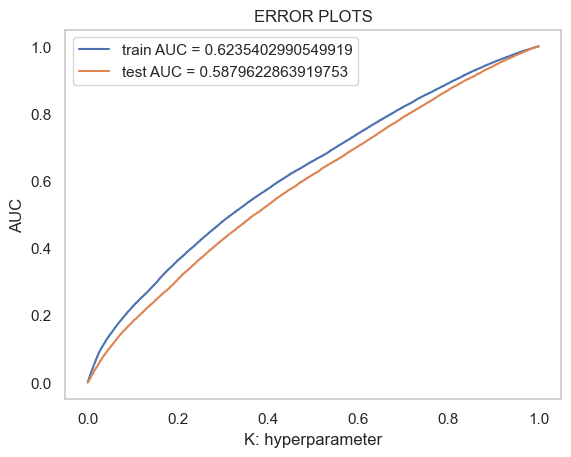

the maximum value of tpr*(1-fpr) 0.3463903373333169 for threshold 0.488
              precision    recall  f1-score   support

           0       0.58      0.62      0.60    127507
           1       0.59      0.56      0.58    127507

    accuracy                           0.59    255014
   macro avg       0.59      0.59      0.59    255014
weighted avg       0.59      0.59      0.59    255014

              precision    recall  f1-score   support

           0       0.68      0.57      0.62     68916
           1       0.45      0.56      0.50     42726

    accuracy                           0.56    111642
   macro avg       0.56      0.56      0.56    111642
weighted avg       0.59      0.56      0.57    111642

Model test F1 score is :  0.4958826823753915
Model test AUC score is :  0.5879622863919753


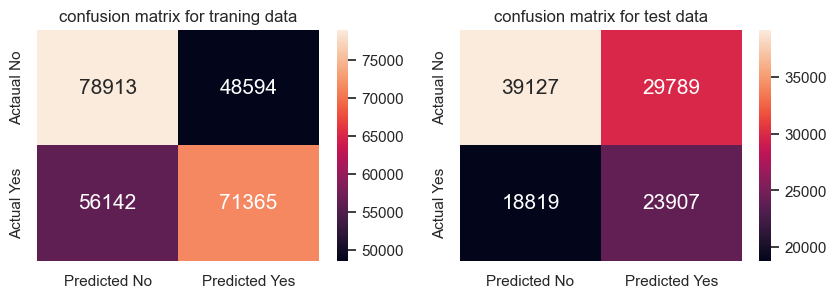

In [143]:
lr_model_f1_score, lr_model_AUC_score = model_performence_check(logreg2,X_train,X_val,y_train,y_val)


###### Model 2: Decision Tree

In [111]:
DT_model = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10,20, 45, 75, 100, 135, 270, 500]}

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)
print("roc_auc :",DT_model_CV.best_score_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV 2/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 5/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 2/5; 2/63] START max_depth=1, min_samples_split=10..........................
[CV 3/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 3/5; 2/63] START max_depth=1, min_samples_split=10..........................
[CV 1/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 4/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 1/5; 2/63] START max_depth=1, min_samples_split=10..........................
[CV 2/5; 2/63] END max_depth=1, min_samples_split=10;, score=(train=0.540, test=0.538) total time=   1.2s
[CV 1/5; 1/63] END max_depth=1, min_samples_split=5;, score=(train=0.540, test=0.538) total time=   1.2s
[CV 4/5; 2/63] START max_depth=1, min_samples_split=10.........................

In [187]:
# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 500, min_samples_split = 135)
DT_model2=DT_model2.fit(X_train,y_train)

print("score",DT_model2.score(X_val,y_val))


score 0.728856523530571


[Text(0.6588588938430293, 0.9833333333333333, 'x[8] <= 1.0\ngini = 0.5\nsamples = 255014\nvalue = [127507, 127507]'),
 Text(0.34111361448241884, 0.95, 'x[3] <= 10.5\ngini = 0.499\nsamples = 237133\nvalue = [123581, 113552]'),
 Text(0.07036581718700972, 0.9166666666666666, 'x[6] <= 145.0\ngini = 0.478\nsamples = 54997\nvalue = [21697, 33300]'),
 Text(0.030235134923125195, 0.8833333333333333, 'x[3] <= 4.5\ngini = 0.444\nsamples = 15299\nvalue = [10205, 5094]'),
 Text(0.014668967681204894, 0.85, 'x[6] <= 75.0\ngini = 0.352\nsamples = 5319\nvalue = [4107, 1212]'),
 Text(0.010511452776906181, 0.8166666666666667, 'x[6] <= 65.0\ngini = 0.315\nsamples = 3838\nvalue = [3087, 751]'),
 Text(0.006589268904926263, 0.7833333333333333, 'x[0] <= 1.5\ngini = 0.33\nsamples = 3341\nvalue = [2644, 697]'),
 Text(0.004392845936617509, 0.75, 'x[6] <= 5.0\ngini = 0.31\nsamples = 2497\nvalue = [2019, 478]'),
 Text(0.0037652965171007216, 0.7166666666666667, 'gini = 0.483\nsamples = 44\nvalue = [26, 18]'),
 Text

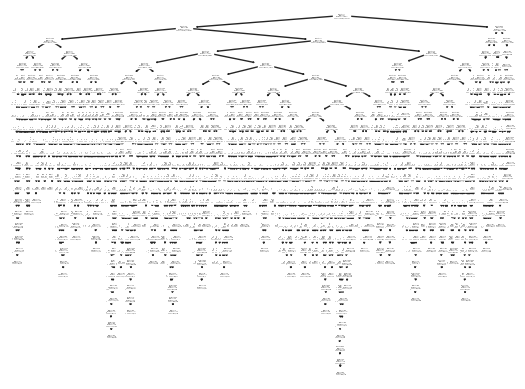

In [281]:
tree.plot_tree(DT_model2)

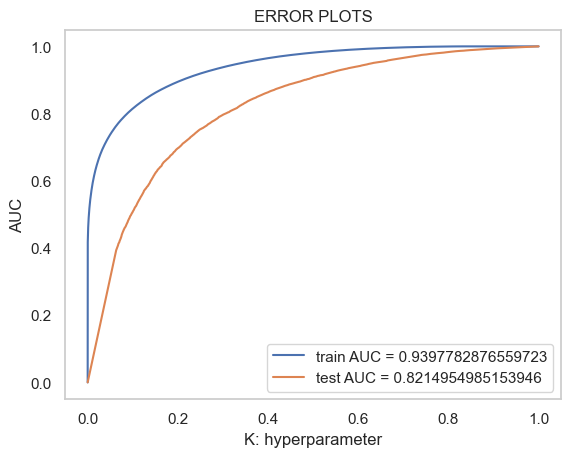

the maximum value of tpr*(1-fpr) 0.7355512893752527 for threshold 0.489
              precision    recall  f1-score   support

           0       0.84      0.88      0.86    127507
           1       0.87      0.84      0.86    127507

    accuracy                           0.86    255014
   macro avg       0.86      0.86      0.86    255014
weighted avg       0.86      0.86      0.86    255014

              precision    recall  f1-score   support

           0       0.86      0.66      0.75     68916
           1       0.60      0.82      0.69     42726

    accuracy                           0.72    111642
   macro avg       0.73      0.74      0.72    111642
weighted avg       0.76      0.72      0.73    111642

Model test F1 score is :  0.6948846976781045
Model test AUC score is :  0.8214954985153946


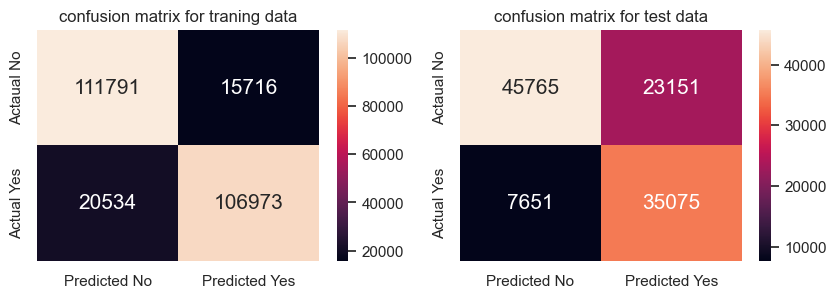

In [188]:
dt_model_f1_score, dt_model_AUC_score = model_performence_check(DT_model2,X_train,X_val,y_train,y_val)


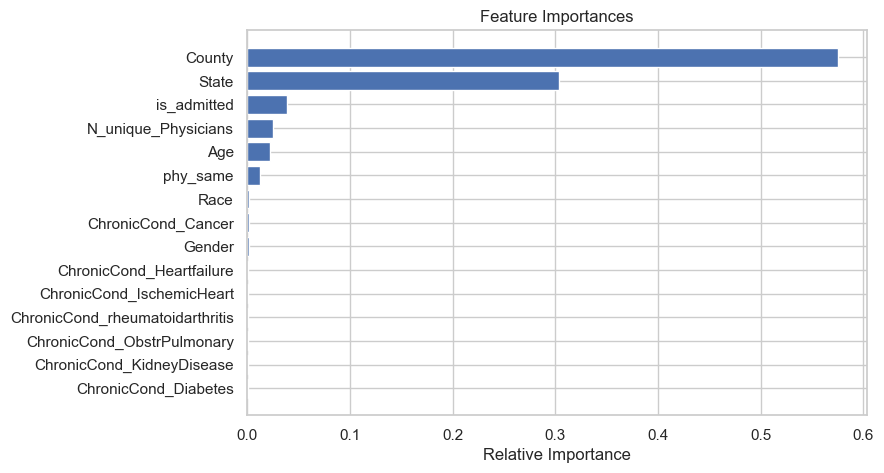

In [189]:
features = X_train.columns
importances = DT_model2.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(8,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Model 3: Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = { 
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 2/5; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 4/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300
[CV 3/5; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 2/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300[CV 1/5; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500

[CV 5/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300
[CV 3/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300
[CV 1/5; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

[CV 5/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.668, test=0.697) total time=  28.6s
[CV 4/5; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.683, test=0.660) total time=  29.2s
[CV 2/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.682, test=0.661) total time=  29.3s
[CV 4/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.683, test=0.665) total time=  29.3s
[CV 5/5; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 1/5; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300
[CV 2/5; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300
[CV 3/5; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.685, test=0.661) total time=  29.7s
[CV 3/5; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=(train=0.683, test=0.662) total time=  47.3s
[CV 4/5; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300
[CV 1/5; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=(train=0.683, test=0.661) total time=  48.1s
[CV 5/5; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300
[CV 3/5; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=(train=0.684, test=0.661) total time=  48.3s
[CV 1/5; 4/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500
[CV 1/5; 3/60] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300;, score=(train=0.683, test=0.660) total time=  28.6s
[CV 2/5; 4/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500
[CV 2/5; 3/60] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300;, score=(train=0.682, te

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 4/60] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=(train=0.668, test=0.696) total time=  47.5s
[CV 2/5; 7/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 5/60] END criterion=gini, max_depth=4, max_features=log2, n_estimators=300;, score=(train=0.660, test=0.690) total time=  25.4s
[CV 3/5; 7/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 6/60] END criterion=gini, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.678, test=0.654) total time=  41.1s
[CV 4/5; 7/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 6/60] END criterion=gini, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.654) total time=  41.1s
[CV 5/5; 7/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 6/60] END criterion=gini, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.652) total time=  40.5s
[CV 1/5; 8/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=500
[CV 4/5; 6/60] END criterion=gini, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.658) total time=  40.6s
[CV 2/5; 8/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 6/60] END criterion=gini, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.663, test=0.693) total time=  40.8s
[CV 3/5; 8/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 7/60] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.692, test=0.669) total time=  34.0s
[CV 4/5; 8/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 7/60] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.691, test=0.669) total time=  34.1s
[CV 5/5; 8/60] START criterion=gini, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 7/60] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.690, test=0.666) total time=  34.6s
[CV 1/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300
[CV 4/5; 7/60] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.692, test=0.673) total time=  35.0s
[CV 2/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300
[CV 5/5; 7/60] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.675, test=0.705) total time=  35.4s
[CV 3/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300
[CV 1/5; 9/60] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300;, score=(train=0.692, test=0.669) total time=  34.8s
[CV 4/5; 9/60] START criterion=gini, max_depth=5, max_features=sqrt, n_estimators=300
[CV 1/5; 8/60] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=(train=0.691, te

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 11/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=300;, score=(train=0.684, test=0.664) total time=  31.0s
[CV 2/5; 13/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 11/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=300;, score=(train=0.670, test=0.699) total time=  31.4s
[CV 3/5; 13/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 13/60] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.675) total time=  42.0s
[CV 4/5; 13/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 12/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.685, test=0.660) total time=  52.1s
[CV 5/5; 13/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 13/60] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.700, test=0.677) total time=  42.0s
[CV 1/5; 14/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 12/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.684, test=0.662) total time=  52.2s
[CV 2/5; 14/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 12/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.686, test=0.659) total time=  51.5s
[CV 3/5; 14/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=500
[CV 4/5; 12/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.684, test=0.664) total time=  51.6s
[CV 4/5; 14/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 12/60] END criterion=gini, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.670, test=0.699) total time=  51.1s
[CV 5/5; 14/60] START criterion=gini, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 13/60] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.673) total time=  42.3s
[CV 1/5; 15/60] START criterion=gini, max_depth=6, max_features=sqrt, n_estimators=300
[CV 4/5; 13/60] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.679) total time=  43.5s
[CV 2/5; 15/60] START criterion=gini, max_depth=6, max_features=sqrt, n_estimators=300
[CV 5/5; 13/60] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.681, test=0.710) total time=  43.0s
[CV 3/5; 15/60] START criterion=gini, max_depth=6, max_features=sqrt, n_estimators=300
[CV 1/5; 15/60] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=300;, score=(train=0.699, test=0.675) total time=  43.6s
[CV 4/5; 15/60] START criterion=gini, max_depth=6, max_features=sqrt, n_estimators=300
[CV 1/5; 14/60] END criterion=gini, max_depth=6, max_features=auto, n_estimators=500;, score=(train=

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 17/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=300;, score=(train=0.692, test=0.671) total time=  40.2s
[CV 2/5; 19/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 17/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=300;, score=(train=0.675, test=0.704) total time=  40.9s
[CV 3/5; 19/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 19/60] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.705, test=0.680) total time=  54.5s
[CV 4/5; 19/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 18/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.693, test=0.666) total time= 1.1min
[CV 5/5; 19/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=300
[CV 2/5; 18/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.692, test=0.669) total time= 1.1min
[CV 1/5; 20/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 18/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.692, test=0.667) total time= 1.1min
[CV 2/5; 20/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 19/60] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.705, test=0.681) total time=  55.0s
[CV 3/5; 20/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 18/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.693, test=0.672) total time= 1.1min
[CV 4/5; 20/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 18/60] END criterion=gini, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.676, test=0.706) total time= 1.1min
[CV 5/5; 20/60] START criterion=gini, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 19/60] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.707, test=0.680) total time=  53.9s
[CV 1/5; 21/60] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300
[CV 4/5; 19/60] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.706, test=0.685) total time=  54.7s
[CV 2/5; 21/60] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300
[CV 5/5; 19/60] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.691, test=0.717) total time=  55.5s
[CV 3/5; 21/60] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300
[CV 1/5; 21/60] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300;, score=(train=0.705, test=0.680) total time=  57.3s
[CV 4/5; 21/60] START criterion=gini, max_depth=7, max_features=sqrt, n_estimators=300
[CV 1/5; 20/60] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=(train=

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 23/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=300;, score=(train=0.697, test=0.675) total time=  50.8s
[CV 2/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 23/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=300;, score=(train=0.681, test=0.708) total time=  52.0s
[CV 3/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.715, test=0.688) total time= 1.2min
[CV 4/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 24/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.699, test=0.672) total time= 1.5min
[CV 5/5; 25/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=300
[CV 2/5; 24/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.698, test=0.673) total time= 1.5min
[CV 1/5; 26/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 24/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.698, test=0.670) total time= 1.5min
[CV 2/5; 26/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.711, test=0.685) total time= 1.2min
[CV 3/5; 26/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 24/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.697, test=0.675) total time= 1.5min
[CV 4/5; 26/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 24/60] END criterion=gini, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.682, test=0.709) total time= 1.5min
[CV 5/5; 26/60] START criterion=gini, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.714, test=0.686) total time= 1.3min
[CV 1/5; 27/60] START criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300
[CV 4/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.712, test=0.689) total time= 1.3min
[CV 2/5; 27/60] START criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300
[CV 5/5; 25/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.700, test=0.727) total time= 1.3min
[CV 3/5; 27/60] START criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300
[CV 1/5; 27/60] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300;, score=(train=0.715, test=0.688) total time= 1.3min
[CV 4/5; 27/60] START criterion=gini, max_depth=8, max_features=sqrt, n_estimators=300
[CV 1/5; 26/60] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=(train=

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 29/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=300;, score=(train=0.706, test=0.682) total time= 1.1min
[CV 2/5; 31/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 29/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=300;, score=(train=0.690, test=0.717) total time= 1.2min
[CV 3/5; 31/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 31/60] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.683, test=0.660) total time=  52.6s
[CV 4/5; 31/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 31/60] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.683, test=0.661) total time=  52.1s
[CV 5/5; 31/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 31/60] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.685, test=0.661) total time=  49.0s
[CV 1/5; 32/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 30/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=500;, score=(train=0.706, test=0.677) total time= 2.0min
[CV 2/5; 32/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=500
[CV 4/5; 31/60] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.683, test=0.665) total time=  49.7s
[CV 3/5; 32/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 30/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=500;, score=(train=0.705, test=0.678) total time= 2.0min
[CV 4/5; 32/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 30/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=500;, score=(train=0.706, test=0.677) total time= 2.0min
[CV 5/5; 32/60] START criterion=entropy, max_depth=4, max_features=auto, n_estimators=500
[CV 5/5; 31/60] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.668, test=0.697) total time=  47.6s
[CV 1/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 30/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=500;, score=(train=0.706, test=0.682) total time= 2.0min
[CV 2/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300
[CV 5/5; 30/60] END criterion=gini, max_depth=8, max_features=log2, n_estimators=500;, score=(train=0.691, test=0.717) total time= 2.0min
[CV 3/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300
[CV 1/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300;, score=(train=0.683, test=0.660) total time=  50.6s
[CV 4/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300
[CV 2/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300;, score=(train=0.683, test=0.661) total time=  50.9s
[CV 5/5; 33/60] START criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=300
[CV 3/5; 33/60] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimator

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 35/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=300;, score=(train=0.676, test=0.657) total time=18.2min
[CV 2/5; 37/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 35/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=300;, score=(train=0.660, test=0.690) total time=18.2min
[CV 3/5; 37/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 36/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.678, test=0.654) total time=34.2min
[CV 4/5; 37/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 36/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.654) total time=34.2min
[CV 5/5; 37/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=300
[CV 3/5; 36/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.652) total time=34.2min
[CV 1/5; 38/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 37/60] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.692, test=0.668) total time=33.0min
[CV 2/5; 38/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 37/60] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.691, test=0.669) total time=50.6min
[CV 3/5; 38/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=500
[CV 4/5; 36/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.658) total time=51.7min
[CV 4/5; 38/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 36/60] END criterion=entropy, max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.662, test=0.693) total time=51.7min
[CV 5/5; 38/60] START criterion=entropy, max_depth=5, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 37/60] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.691, test=0.666) total time=67.1min
[CV 1/5; 39/60] START criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=300
[CV 5/5; 37/60] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.674, test=0.703) total time=34.5min
[CV 2/5; 39/60] START criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=300
[CV 4/5; 37/60] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.692, test=0.672) total time=34.5min
[CV 3/5; 39/60] START criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=300
[CV 1/5; 39/60] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=300;, score=(train=0.692, test=0.668) total time=17.8min
[CV 4/5; 39/60] START criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=300
[CV 1/5; 38/60] END criterion=entropy, max_depth=5, max_features=auto, n_est

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=300;, score=(train=0.684, test=0.664) total time=50.3min
[CV 2/5; 43/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 41/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=300;, score=(train=0.670, test=0.699) total time=43.4min
[CV 3/5; 43/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 43/60] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.700, test=0.676) total time=27.2min
[CV 4/5; 43/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 43/60] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.700, test=0.677) total time=27.2min
[CV 5/5; 43/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 42/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.685, test=0.660) total time=42.5min
[CV 1/5; 44/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 42/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.684, test=0.661) total time=42.5min
[CV 2/5; 44/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 42/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.686, test=0.660) total time=27.3min
[CV 3/5; 44/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 42/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.684, test=0.664) total time=27.3min
[CV 4/5; 44/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 42/60] END criterion=entropy, max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.669, test=0.699) total time=27.3min
[CV 5/5; 44/60] START criterion=entropy, max_depth=6, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 43/60] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.673) total time=34.0min
[CV 1/5; 45/60] START criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=300
[CV 4/5; 43/60] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.700, test=0.680) total time=29.6min
[CV 2/5; 45/60] START criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=300
[CV 5/5; 43/60] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.681, test=0.710) total time=29.6min
[CV 3/5; 45/60] START criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=300
[CV 1/5; 45/60] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=300;, score=(train=0.700, test=0.676) total time=  34.9s
[CV 4/5; 45/60] START criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=300
[CV 2/5; 44/60] END criterion=entropy, max_depth=6, max_features=auto, n_est

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 47/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300;, score=(train=0.692, test=0.672) total time=  28.2s
[CV 2/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 47/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300;, score=(train=0.676, test=0.706) total time=  29.2s
[CV 3/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.705, test=0.680) total time=  37.9s
[CV 4/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 48/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.692, test=0.666) total time=  43.8s
[CV 2/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.704, test=0.679) total time=  36.7s
[CV 5/5; 49/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=300
[CV 1/5; 50/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 48/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.692, test=0.666) total time=  45.5s
[CV 2/5; 50/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=500
[CV 2/5; 48/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.692, test=0.669) total time=  45.8s
[CV 3/5; 50/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 48/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.693, test=0.672) total time=  45.5s
[CV 4/5; 50/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 48/60] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=500;, score=(train=0.677, test=0.707) total time=  44.1s
[CV 5/5; 50/60] START criterion=entropy, max_depth=7, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.705, test=0.678) total time=  36.4s
[CV 1/5; 51/60] START criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=300
[CV 4/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.707, test=0.686) total time=  38.8s
[CV 2/5; 51/60] START criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=300
[CV 5/5; 49/60] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=(train=0.693, test=0.720) total time=  39.2s
[CV 3/5; 51/60] START criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=300
[CV 1/5; 51/60] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=300;, score=(train=0.705, test=0.680) total time=  38.4s
[CV 4/5; 51/60] START criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=300
[CV 1/5; 50/60] END criterion=entropy, max_depth=7, max_features=auto, n_est

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 53/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=300;, score=(train=0.699, test=0.677) total time=  29.9s
[CV 2/5; 55/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 53/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=300;, score=(train=0.682, test=0.711) total time=  29.5s
[CV 3/5; 55/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 55/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.712, test=0.685) total time=  40.7s
[CV 4/5; 55/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 54/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.698, test=0.672) total time=  50.3s
[CV 5/5; 55/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=300


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 55/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.711, test=0.686) total time=  40.6s
[CV 1/5; 56/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=500
[CV 1/5; 54/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.699, test=0.673) total time=  51.3s
[CV 2/5; 56/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 54/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.698, test=0.670) total time=  50.6s
[CV 3/5; 56/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=500
[CV 4/5; 54/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.698, test=0.676) total time=  50.3s
[CV 4/5; 56/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 54/60] END criterion=entropy, max_depth=7, max_features=log2, n_estimators=500;, score=(train=0.682, test=0.710) total time=  50.1s
[CV 5/5; 56/60] START criterion=entropy, max_depth=8, max_features=auto, n_estimators=500


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 55/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.715, test=0.686) total time=  41.7s
[CV 1/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=300
[CV 4/5; 55/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.714, test=0.691) total time=  41.6s
[CV 2/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=300
[CV 5/5; 55/60] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=(train=0.701, test=0.727) total time=  41.6s
[CV 3/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=300
[CV 1/5; 57/60] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=300;, score=(train=0.712, test=0.685) total time=  41.4s
[CV 4/5; 57/60] START criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=300
[CV 1/5; 56/60] END criterion=entropy, max_depth=8, max_features=auto, n_est

In [192]:
RF2 = RandomForestClassifier(n_estimators = 500,max_features='auto',max_depth=8,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42
                             )

RF2=RF2.fit(X_train,y_train)

print("score",RF2.score(X_val,y_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


building tree 1 of 500building tree 2 of 500

building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s


building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.6s


building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.1s


building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.3s


building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.6s


building tree 81 of 500
building tree 82 of 500
building tree 83 of 500
building tree 84 of 500
building tree 85 of 500
building tree 86 of 500
building tree 87 of 500
building tree 88 of 500
building tree 89 of 500
building tree 90 of 500
building tree 91 of 500
building tree 92 of 500


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.8s


building tree 93 of 500
building tree 94 of 500
building tree 95 of 500
building tree 96 of 500
building tree 97 of 500
building tree 98 of 500
building tree 99 of 500
building tree 100 of 500
building tree 101 of 500
building tree 102 of 500
building tree 103 of 500
building tree 104 of 500
building tree 105 of 500
building tree 106 of 500
building tree 107 of 500
building tree 108 of 500
building tree 109 of 500
building tree 110 of 500
building tree 111 of 500
building tree 112 of 500
building tree 113 of 500
building tree 114 of 500


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.1s


building tree 115 of 500
building tree 116 of 500
building tree 117 of 500
building tree 118 of 500
building tree 119 of 500
building tree 120 of 500
building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.4s


building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500building tree 137 of 500

building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    2.7s


building tree 149 of 500building tree 150 of 500

building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.1s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    3.5s


building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.9s


building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500
building tree 210 of 500
building tree 211 of 500
building tree 212 of 500
building tree 213 of 500
building tree 214 of 500
building tree 215 of 500


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    4.4s


building tree 216 of 500
building tree 217 of 500
building tree 218 of 500
building tree 219 of 500
building tree 220 of 500
building tree 221 of 500
building tree 222 of 500
building tree 223 of 500
building tree 224 of 500
building tree 225 of 500
building tree 226 of 500
building tree 227 of 500
building tree 228 of 500
building tree 229 of 500
building tree 230 of 500
building tree 231 of 500
building tree 232 of 500
building tree 233 of 500
building tree 234 of 500
building tree 235 of 500
building tree 236 of 500
building tree 237 of 500
building tree 238 of 500


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    4.8s


building tree 239 of 500
building tree 240 of 500
building tree 241 of 500
building tree 242 of 500
building tree 243 of 500
building tree 244 of 500
building tree 245 of 500
building tree 246 of 500
building tree 247 of 500
building tree 248 of 500
building tree 249 of 500
building tree 250 of 500
building tree 251 of 500
building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500
building tree 256 of 500
building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    5.2s


building tree 261 of 500building tree 262 of 500
building tree 263 of 500

building tree 264 of 500
building tree 265 of 500
building tree 266 of 500
building tree 267 of 500
building tree 268 of 500
building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500
building tree 275 of 500
building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.7s


building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500


[Parallel(n_jobs=-1)]: Done 297 tasks      | elapsed:    6.2s


building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500
building tree 323 of 500
building tree 324 of 500
building tree 325 of 500
building tree 326 of 500
building tree 327 of 500
building tree 328 of 500
building tree 329 of 500
building tree 330 of 500
building tree 331 of 500
building tree 332 of 500
building tree 333 of 500
building tree 334 of 500
building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500


[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    6.7s


building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    7.2s


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500


[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.7s


building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500
building tree 405 of 500
building tree 406 of 500
building tree 407 of 500
building tree 408 of 500
building tree 409 of 500
building tree 410 of 500
building tree 411 of 500
building tree 412 of 500
building tree 413 of 500
building tree 414 of 500
building tree 415 of 500
building tree 416 of 500
building tree 417 of 500
building tree 418 of 500
building tree 419 of 500
building tree 420 of 500
building tree 421 of 500


[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:    8.3s


building tree 422 of 500
building tree 423 of 500
building tree 424 of 500
building tree 425 of 500
building tree 426 of 500
building tree 427 of 500
building tree 428 of 500
building tree 429 of 500
building tree 430 of 500
building tree 431 of 500
building tree 432 of 500
building tree 433 of 500
building tree 434 of 500
building tree 435 of 500
building tree 436 of 500
building tree 437 of 500
building tree 438 of 500
building tree 439 of 500
building tree 440 of 500
building tree 441 of 500
building tree 442 of 500
building tree 443 of 500


[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.9s


building tree 444 of 500
building tree 445 of 500
building tree 446 of 500
building tree 447 of 500
building tree 448 of 500
building tree 449 of 500
building tree 450 of 500
building tree 451 of 500
building tree 452 of 500
building tree 453 of 500
building tree 454 of 500
building tree 455 of 500
building tree 456 of 500
building tree 457 of 500
building tree 458 of 500
building tree 459 of 500
building tree 460 of 500
building tree 461 of 500
building tree 462 of 500
building tree 463 of 500
building tree 464 of 500
building tree 465 of 500
building tree 466 of 500
building tree 467 of 500
building tree 468 of 500
building tree 469 of 500
building tree 470 of 500
building tree 471 of 500
building tree 472 of 500
building tree 473 of 500
building tree 474 of 500
building tree 475 of 500


[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:    9.5s


building tree 476 of 500building tree 477 of 500

building tree 478 of 500
building tree 479 of 500
building tree 480 of 500
building tree 481 of 500
building tree 482 of 500
building tree 483 of 500
building tree 484 of 500
building tree 485 of 500
building tree 486 of 500
building tree 487 of 500
building tree 488 of 500
building tree 489 of 500
building tree 490 of 500
building tree 491 of 500
building tree 492 of 500
building tree 493 of 500
building tree 494 of 500
building tree 495 of 500
building tree 496 of 500
building tree 497 of 500
building tree 498 of 500
building tree 499 of 500
building tree 500 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   10.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    

score 0.6203937586213074


[Parallel(n_jobs=8)]: Done 322 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 376 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 405 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 465 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s


[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 226 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 249 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 297 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 322 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 376 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Do

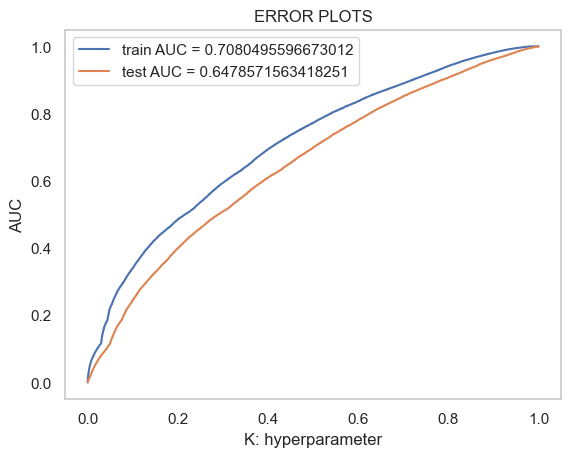

the maximum value of tpr*(1-fpr) 0.41785804247099706 for threshold 0.47
              precision    recall  f1-score   support

           0       0.65      0.63      0.64    127507
           1       0.64      0.67      0.65    127507

    accuracy                           0.65    255014
   macro avg       0.65      0.65      0.65    255014
weighted avg       0.65      0.65      0.65    255014

              precision    recall  f1-score   support

           0       0.72      0.54      0.62     68916
           1       0.47      0.66      0.55     42726

    accuracy                           0.59    111642
   macro avg       0.60      0.60      0.58    111642
weighted avg       0.63      0.59      0.59    111642

Model test F1 score is :  0.5516872819845119
Model test AUC score is :  0.6478571563418251


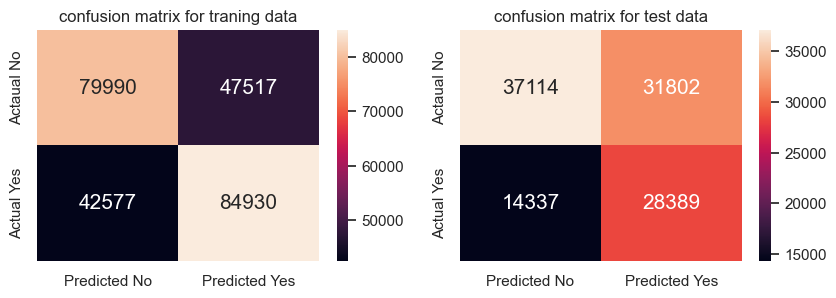

In [193]:
rf_model_f1_score, rf_model_AUC_score = model_performence_check(RF2,X_train,X_val,y_train,y_val)

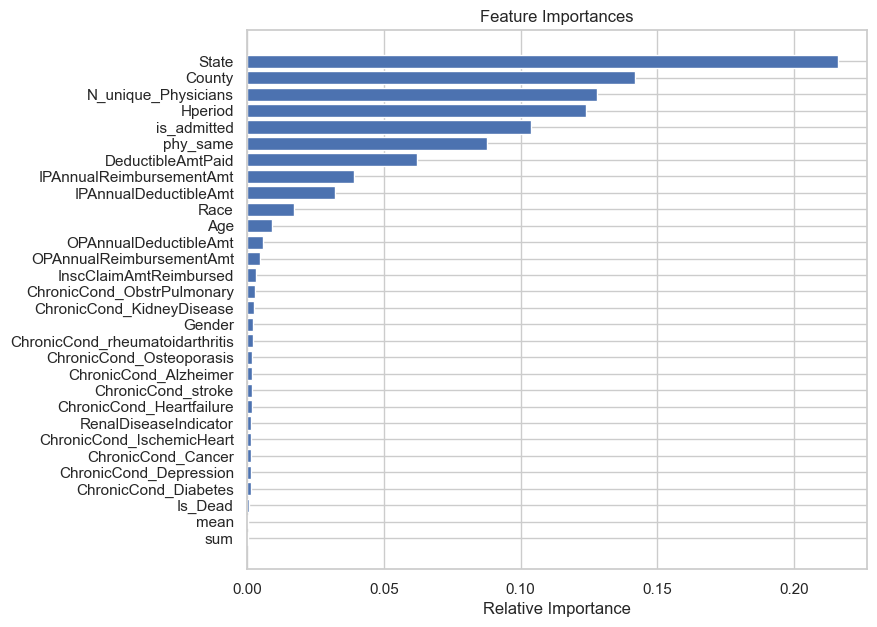

In [122]:
features = X_train.columns
importances = RF2.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Model 4: Xg_Boost

In [123]:
import xgboost as xgb

XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5; 1/10] START eta=0.2, n_estimators=5....................................
[CV 1/5; 1/10] START eta=0.2, n_estimators=5....................................
[CV 5/5; 1/10] START eta=0.2, n_estimators=5....................................
[CV 2/5; 1/10] START eta=0.2, n_estimators=5....................................
[CV 2/5; 2/10] START eta=0.01, n_estimators=75..................................
[CV 1/5; 2/10] START eta=0.01, n_estimators=75..................................
[CV 3/5; 1/10] START eta=0.2, n_estimators=5....................................
[CV 3/5; 2/10] START eta=0.01, n_estimators=75..................................
[CV 4/5; 1/10] END eta=0.2, n_estimators=5;, score=(train=0.761, test=0.751) total time=   3.6s
[CV 4/5; 2/10] START eta=0.01, n_estimators=75..................................
[CV 3/5; 1/10] END eta=0.2, n_estimators=5;, score=(train=0.752, test=0.739) total time=   3.6s
[CV 5/5; 2/10] STA

In [198]:
XGB2 = xgb.XGBClassifier(eta=0.1,n_estimators=100,n_jobs=-1)

XGB2=XGB2.fit(X_train,y_train)

print("score",XGB2.score(X_val,y_val))

score 0.7028358503072321


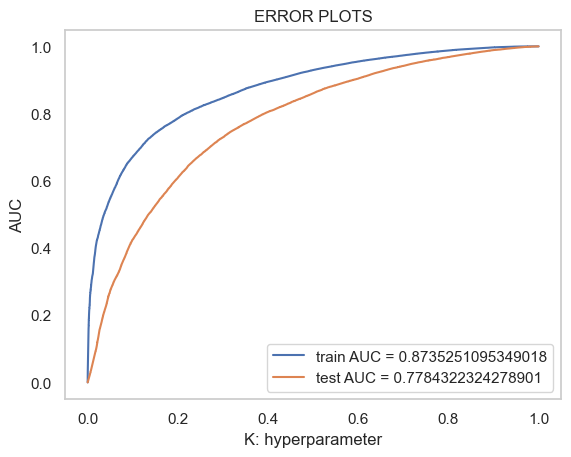

the maximum value of tpr*(1-fpr) 0.6317796595371333 for threshold 0.496
              precision    recall  f1-score   support

           0       0.78      0.83      0.80    127507
           1       0.82      0.76      0.79    127507

    accuracy                           0.80    255014
   macro avg       0.80      0.80      0.80    255014
weighted avg       0.80      0.80      0.80    255014

              precision    recall  f1-score   support

           0       0.82      0.67      0.73     68916
           1       0.59      0.76      0.66     42726

    accuracy                           0.70    111642
   macro avg       0.70      0.71      0.70    111642
weighted avg       0.73      0.70      0.71    111642

Model test F1 score is :  0.6605583130344386
Model test AUC score is :  0.7784322324278901


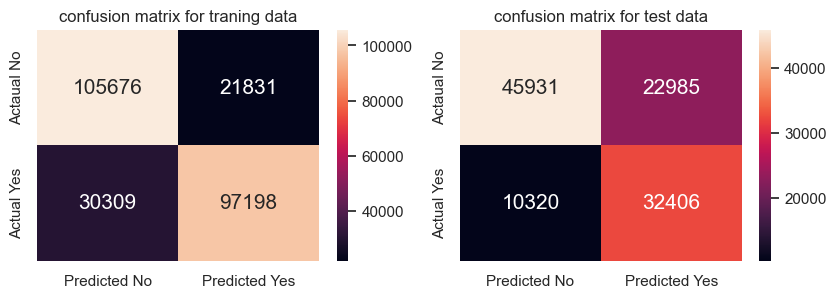

In [199]:
xg_model_f1_score, xg_model_AUC_score = model_performence_check(XGB2,X_train,X_val,y_train,y_val)

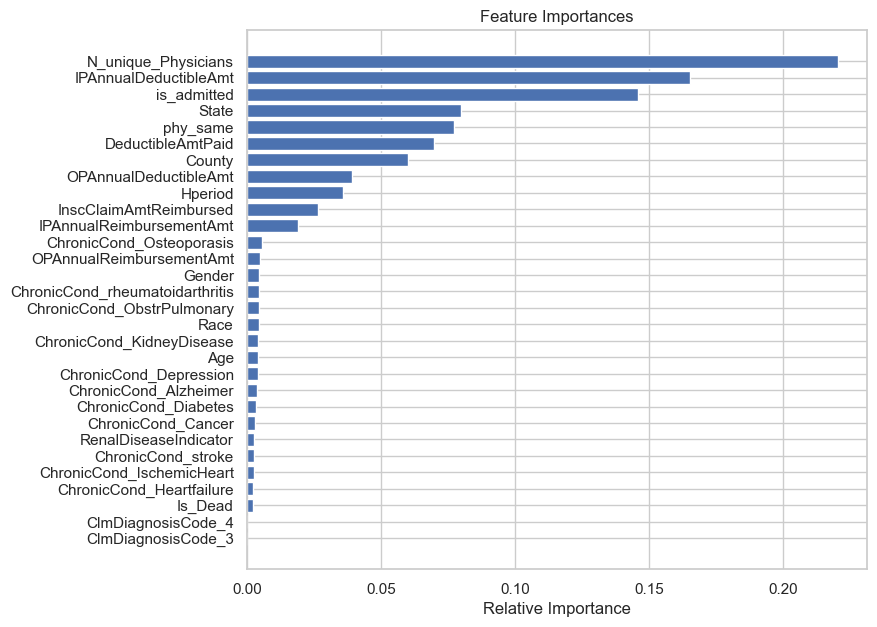

In [200]:
features = X_train.columns
importances = XGB2.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### plot model performence summary graph


In [127]:
def model_comp(model=[],metric1=[],metric2=[],set_ylabel='',set_title='',metric1_label='',metric2_label=''):
    
    x = np.arange(len(model))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(12,5))
    rects1 = ax.bar(x - width/2, metric1, width, label=metric1_label,color = 'teal')
    rects2 = ax.bar(x + width/2, metric2, width, label=metric2_label)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(set_ylabel)
    ax.set_title(set_title)
    ax.set_xticks(x)
    ax.set_xticklabels(model)
    ax.legend()
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    
    fig.tight_layout()

    plt.show()

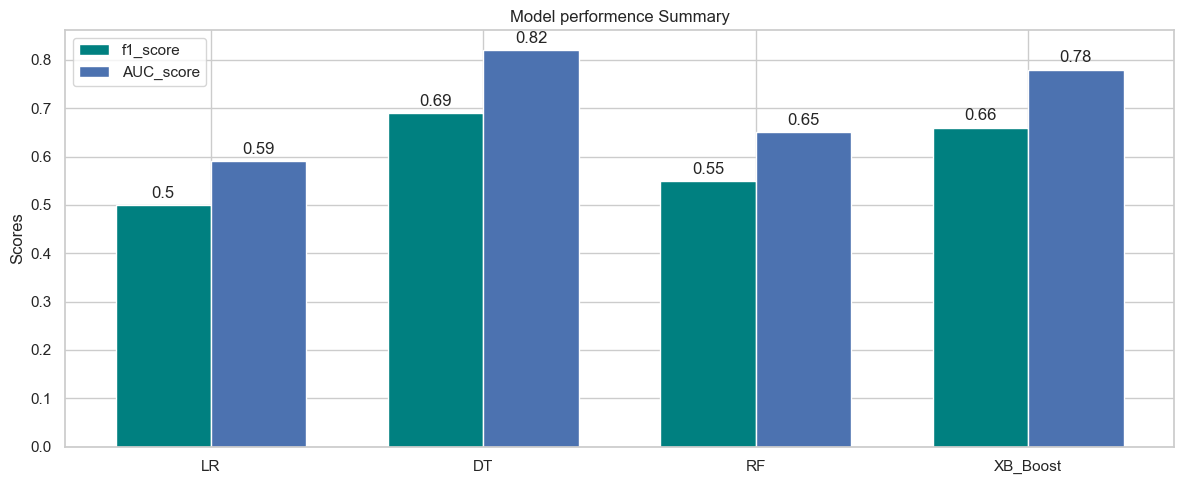

In [201]:
model = ['LR','DT','RF','XB_Boost']
f1_score = [round(num, 2) for num in [lr_model_f1_score,dt_model_f1_score, rf_model_f1_score, xg_model_f1_score]]
AUC_score = [round(num, 2) for num in [lr_model_AUC_score,dt_model_AUC_score,rf_model_AUC_score,xg_model_AUC_score]]

model_comp(model,f1_score,AUC_score,'Scores','Model performence Summary','f1_score','AUC_score')

In [202]:
model_performence_df = pd.DataFrame()
model = ['LR','DT','RF','XB_Boost']
f1_score = [round(num, 2) for num in [lr_model_f1_score,dt_model_f1_score, rf_model_f1_score, xg_model_f1_score]]
AUC_score = [round(num, 2) for num in [lr_model_AUC_score,dt_model_AUC_score,rf_model_AUC_score,xg_model_AUC_score]]

model_performence_df['Model']=model
model_performence_df['f1_score']=f1_score
model_performence_df['AUC_score']=AUC_score
model_performence_df

,Model,f1_score,AUC_score
0,LR,0.50,0.59
1,DT,0.69,0.82
2,RF,0.55,0.65
3,XB_Boost,0.66,0.78


##### Situation2: using Important features


In [136]:
features = X_train.columns
importances = XGB2.feature_importances_
indices = (np.argsort(importances))[-30:]
[features[i] for i in indices]

['ClmDiagnosisCode_3',
 'ClmDiagnosisCode_4',
 'Is_Dead',
 'ChronicCond_Heartfailure',
 'ChronicCond_IschemicHeart',
 'ChronicCond_stroke',
 'RenalDiseaseIndicator',
 'ChronicCond_Cancer',
 'ChronicCond_Diabetes',
 'ChronicCond_Alzheimer',
 'ChronicCond_Depression',
 'Age',
 'ChronicCond_KidneyDisease',
 'Race',
 'ChronicCond_ObstrPulmonary',
 'ChronicCond_rheumatoidarthritis',
 'Gender',
 'OPAnnualReimbursementAmt',
 'ChronicCond_Osteoporasis',
 'IPAnnualReimbursementAmt',
 'InscClaimAmtReimbursed',
 'Hperiod',
 'OPAnnualDeductibleAmt',
 'County',
 'DeductibleAmtPaid',
 'phy_same',
 'State',
 'is_admitted',
 'IPAnnualDeductibleAmt',
 'N_unique_Physicians']

In [137]:
# based on agboost, select top 30 important features
importances = XGB2.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] >0]
top_30_features = feature_importance_df.head(30)
Important_col = top_30_features['Feature'].tolist()

print(Important_col)




['N_unique_Physicians', 'IPAnnualDeductibleAmt', 'is_admitted', 'State', 'phy_same', 'DeductibleAmtPaid', 'County', 'OPAnnualDeductibleAmt', 'Hperiod', 'InscClaimAmtReimbursed', 'IPAnnualReimbursementAmt', 'ChronicCond_Osteoporasis', 'OPAnnualReimbursementAmt', 'Gender', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_ObstrPulmonary', 'Race', 'ChronicCond_KidneyDisease', 'Age', 'ChronicCond_Depression', 'ChronicCond_Alzheimer', 'ChronicCond_Diabetes', 'ChronicCond_Cancer', 'RenalDiseaseIndicator', 'ChronicCond_stroke', 'ChronicCond_IschemicHeart', 'ChronicCond_Heartfailure', 'Is_Dead']


In [138]:
X_train1 = X_train[Important_col]
X_train1.head(5)

,N_unique_Physicians,IPAnnualDeductibleAmt,is_admitted,State,phy_same,DeductibleAmtPaid,County,OPAnnualDeductibleAmt,Hperiod,InscClaimAmtReimbursed,...,Age,ChronicCond_Depression,ChronicCond_Alzheimer,ChronicCond_Diabetes,ChronicCond_Cancer,RenalDiseaseIndicator,ChronicCond_stroke,ChronicCond_IschemicHeart,ChronicCond_Heartfailure,Is_Dead
0,1,0.0,0,11,1,0.0,842,1.0,0.0,1.0,...,88,0,0,1,0,0,0,1,1,0
1,1,1.0,0,20,2,0.0,90,1.0,0.0,1.0,...,51,0,0,1,0,0,0,1,1,0
2,1,1.0,0,45,4,0.0,610,1.0,0.0,1.0,...,79,1,1,1,0,0,0,1,1,0
3,2,1.0,0,42,1,0.0,330,1.0,0.0,1.0,...,84,1,1,0,0,0,0,1,1,0
4,2,0.0,0,10,4,0.0,40,1.0,0.0,1.0,...,65,0,0,1,1,1,0,1,1,0


In [139]:
X_val1 = X_val[Important_col]
X_val1.head(5)

,N_unique_Physicians,IPAnnualDeductibleAmt,is_admitted,State,phy_same,DeductibleAmtPaid,County,OPAnnualDeductibleAmt,Hperiod,InscClaimAmtReimbursed,...,Age,ChronicCond_Depression,ChronicCond_Alzheimer,ChronicCond_Diabetes,ChronicCond_Cancer,RenalDiseaseIndicator,ChronicCond_stroke,ChronicCond_IschemicHeart,ChronicCond_Heartfailure,Is_Dead
149483,1,0.0,0,1,2,0.0,400,1.0,0.0,1.0,...,29,0,0,0,0,0,0,1,0,0
368178,1,0.0,0,12,4,0.0,20,1.0,0.0,1.0,...,70,0,1,0,0,0,0,1,0,0
548478,1,0.0,0,45,2,0.0,220,1.0,0.0,1.0,...,71,0,0,0,0,0,0,1,1,0
280143,1,1.0,0,21,4,0.0,220,1.0,0.0,1.0,...,74,1,0,1,0,1,0,1,1,0
2565,2,1.0,0,39,4,0.0,270,1.0,0.0,1.0,...,84,1,1,1,0,0,1,1,1,0


###### Model 1 : LR

In [140]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10,  n_jobs=-1, return_train_score=True)
logreg_cv.fit(X_train1,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the d

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.5889638715661628


In [141]:
# use optimized parameters to train the model
logreg2=LogisticRegression(C=0.1,penalty="l2")
logreg2.fit(X_train1,y_train)
print("score",logreg2.score(X_val1,y_val))

score 0.5767005248920657


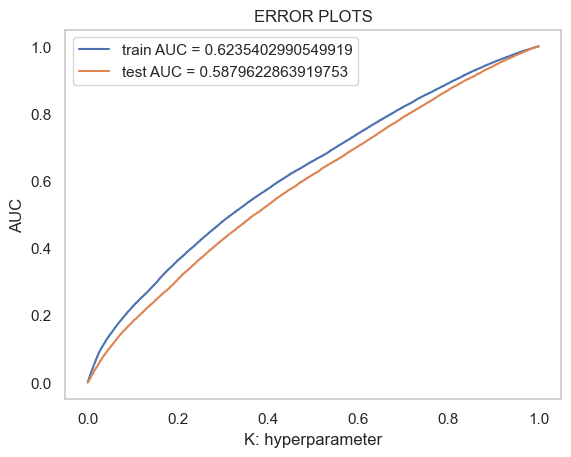

the maximum value of tpr*(1-fpr) 0.3463903373333169 for threshold 0.488
              precision    recall  f1-score   support

           0       0.58      0.62      0.60    127507
           1       0.59      0.56      0.58    127507

    accuracy                           0.59    255014
   macro avg       0.59      0.59      0.59    255014
weighted avg       0.59      0.59      0.59    255014

              precision    recall  f1-score   support

           0       0.68      0.57      0.62     68916
           1       0.45      0.56      0.50     42726

    accuracy                           0.56    111642
   macro avg       0.56      0.56      0.56    111642
weighted avg       0.59      0.56      0.57    111642

Model test F1 score is :  0.4958826823753915
Model test AUC score is :  0.5879622863919753


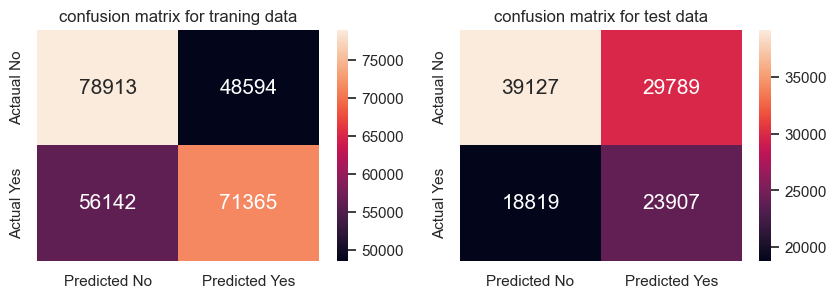

In [144]:
lr_fea_model_f1_score, lr_fea_model_AUC_score = model_performence_check(logreg2,X_train1,X_val1,y_train,y_val)


###### Model 2: Decision Tree

In [145]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier(class_weight = 'balanced')

parameters = {'max_depth': [1, 5, 10, 50, 100, 500, 1000], 'min_samples_split': [5, 10,20, 45, 75, 100, 135, 270, 500]}

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(X_train1,y_train)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)
print("roc_auc :",DT_model_CV.best_score_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[CV 5/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 2/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 4/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 3/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 1/5; 2/63] START max_depth=1, min_samples_split=10..........................
[CV 1/5; 1/63] START max_depth=1, min_samples_split=5...........................
[CV 3/5; 2/63] START max_depth=1, min_samples_split=10..........................
[CV 2/5; 2/63] START max_depth=1, min_samples_split=10..........................
[CV 5/5; 1/63] END max_depth=1, min_samples_split=5;, score=(train=0.538, test=0.546) total time=   0.9s
[CV 1/5; 1/63] END max_depth=1, min_samples_split=5;, score=(train=0.540, test=0.538) total time=   0.8s
[CV 4/5; 1/63] END max_depth=1, min_samples_split=5;, score=(train=0.540, test=0.538) total time=   0.8s
[CV 2/5; 1/63] END max_depth=1, min_s

In [207]:
# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight = 'balanced', max_depth = 1000, min_samples_split = 270)
DT_model2=DT_model2.fit(X_train1,y_train)

print("score",DT_model2.score(X_val1,y_val))

score 0.727754787624729


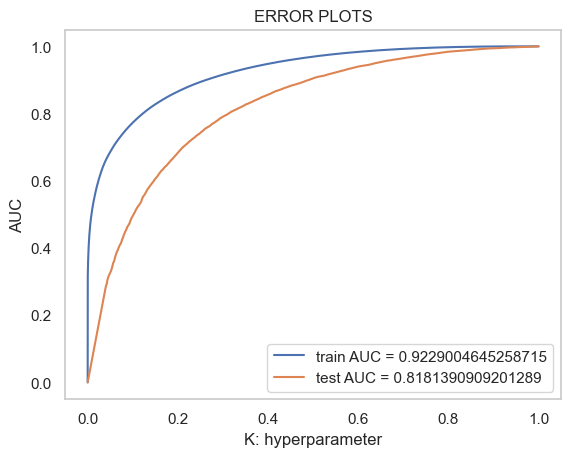

the maximum value of tpr*(1-fpr) 0.7039468404088566 for threshold 0.488
              precision    recall  f1-score   support

           0       0.83      0.86      0.84    127507
           1       0.85      0.82      0.84    127507

    accuracy                           0.84    255014
   macro avg       0.84      0.84      0.84    255014
weighted avg       0.84      0.84      0.84    255014

              precision    recall  f1-score   support

           0       0.85      0.67      0.75     68916
           1       0.60      0.81      0.69     42726

    accuracy                           0.72    111642
   macro avg       0.73      0.74      0.72    111642
weighted avg       0.76      0.72      0.73    111642

Model test F1 score is :  0.6930793878956667
Model test AUC score is :  0.8181390909201289


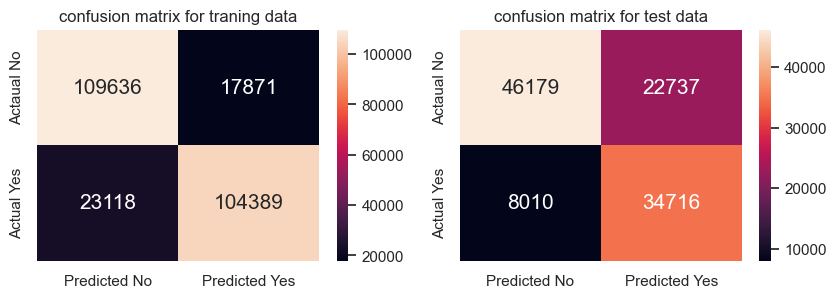

In [208]:
dt_fea_model_f1_score, dt_fea_model_AUC_score = model_performence_check(DT_model2,X_train1,X_val1,y_train,y_val)


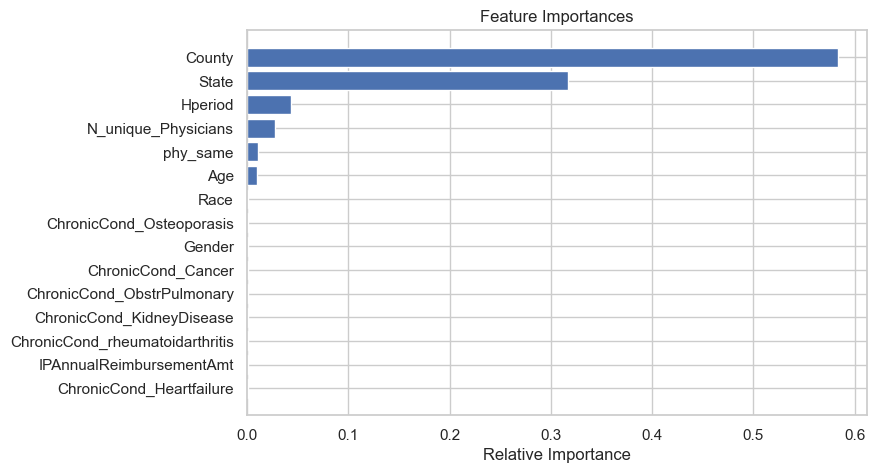

In [209]:
features = X_train1.columns
importances = DT_model2.feature_importances_
indices = (np.argsort(importances))[-15:]
plt.figure(figsize=(8,5))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Model 3: Random Forest

In [149]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(class_weight = 'balanced', random_state=42)

param_grid = { 
    'n_estimators': [300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6],
    # 'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train1, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 2/5; 1/18] START max_depth=4, max_features=auto, n_estimators=300...........
[CV 3/5; 1/18] START max_depth=4, max_features=auto, n_estimators=300...........
[CV 3/5; 2/18] START max_depth=4, max_features=auto, n_estimators=500...........
[CV 1/5; 1/18] START max_depth=4, max_features=auto, n_estimators=300...........
[CV 4/5; 1/18] START max_depth=4, max_features=auto, n_estimators=300...........
[CV 5/5; 1/18] START max_depth=4, max_features=auto, n_estimators=300...........
[CV 1/5; 2/18] START max_depth=4, max_features=auto, n_estimators=500...........
[CV 2/5; 2/18] START max_depth=4, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning:

[CV 2/5; 1/18] END max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.692, test=0.672) total time=  24.9s
[CV 4/5; 2/18] START max_depth=4, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 1/18] END max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.691, test=0.669) total time=  25.2s
[CV 5/5; 2/18] START max_depth=4, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 1/18] END max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.690, test=0.673) total time=  25.7s
[CV 1/5; 3/18] START max_depth=4, max_features=sqrt, n_estimators=300...........
[CV 5/5; 1/18] END max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.676, test=0.707) total time=  25.6s
[CV 2/5; 3/18] START max_depth=4, max_features=sqrt, n_estimators=300...........
[CV 1/5; 1/18] END max_depth=4, max_features=auto, n_estimators=300;, score=(train=0.691, test=0.671) total time=  26.6s
[CV 3/5; 3/18] START max_depth=4, max_features=sqrt, n_estimators=300...........
[CV 3/5; 2/18] END max_depth=4, max_features=auto, n_estimators=500;, score=(train=0.691, test=0.669) total time=  42.3s
[CV 4/5; 3/18] START max_depth=4, max_features=sqrt, n_estimators=300...........
[CV 2/5; 2/18] END max_depth=4, max_features=auto, n_estimators=500;, score=(train=0.691, test=0.672) total time=  42.8s
[CV 1/5; 2/18] END max_depth=4, max_features=auto, n_estimators=500;, s

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 4/18] END max_depth=4, max_features=sqrt, n_estimators=500;, score=(train=0.676, test=0.705) total time=  39.6s
[CV 2/5; 7/18] START max_depth=5, max_features=auto, n_estimators=300...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 5/18] END max_depth=4, max_features=log2, n_estimators=300;, score=(train=0.672, test=0.704) total time=  21.3s
[CV 3/5; 7/18] START max_depth=5, max_features=auto, n_estimators=300...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 6/18] END max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.688, test=0.668) total time=  35.6s
[CV 1/5; 6/18] END max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.689, test=0.667) total time=  35.7s
[CV 4/5; 7/18] START max_depth=5, max_features=auto, n_estimators=300...........
[CV 5/5; 7/18] START max_depth=5, max_features=auto, n_estimators=300...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 6/18] END max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.688, test=0.671) total time=  35.6s
[CV 1/5; 8/18] START max_depth=5, max_features=auto, n_estimators=500...........
[CV 5/5; 6/18] END max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.673, test=0.704) total time=  35.1s
[CV 2/5; 8/18] START max_depth=5, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 6/18] END max_depth=4, max_features=log2, n_estimators=500;, score=(train=0.689, test=0.666) total time=  35.8s
[CV 3/5; 8/18] START max_depth=5, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 7/18] END max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.677) total time=  28.5s
[CV 4/5; 8/18] START max_depth=5, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 7/18] END max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.678) total time=  28.6s
[CV 5/5; 8/18] START max_depth=5, max_features=auto, n_estimators=500...........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 7/18] END max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.699, test=0.676) total time=  28.7s
[CV 1/5; 9/18] START max_depth=5, max_features=sqrt, n_estimators=300...........
[CV 5/5; 7/18] END max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.687, test=0.720) total time=  28.8s
[CV 2/5; 9/18] START max_depth=5, max_features=sqrt, n_estimators=300...........
[CV 4/5; 7/18] END max_depth=5, max_features=auto, n_estimators=300;, score=(train=0.698, test=0.681) total time=  29.2s
[CV 3/5; 9/18] START max_depth=5, max_features=sqrt, n_estimators=300...........
[CV 1/5; 9/18] END max_depth=5, max_features=sqrt, n_estimators=300;, score=(train=0.699, test=0.677) total time=  27.9s
[CV 4/5; 9/18] START max_depth=5, max_features=sqrt, n_estimators=300...........
[CV 2/5; 8/18] END max_depth=5, max_features=auto, n_estimators=500;, score=(train=0.699, test=0.679) total time=  47.9s
[CV 5/5; 9/18] START max_depth=5, max_features=sqrt, n_estimators=300..

/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 11/18] END max_depth=5, max_features=log2, n_estimators=300;, score=(train=0.695, test=0.676) total time=  27.5s
[CV 2/5; 13/18] START max_depth=6, max_features=auto, n_estimators=300..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5; 11/18] END max_depth=5, max_features=log2, n_estimators=300;, score=(train=0.681, test=0.712) total time=  28.7s
[CV 3/5; 13/18] START max_depth=6, max_features=auto, n_estimators=300..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 13/18] END max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.709, test=0.687) total time=  38.2s
[CV 4/5; 13/18] START max_depth=6, max_features=auto, n_estimators=300..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 13/18] END max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.709, test=0.688) total time=  37.9s
[CV 5/5; 13/18] START max_depth=6, max_features=auto, n_estimators=300..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5; 12/18] END max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.696, test=0.673) total time=  48.1s
[CV 1/5; 14/18] START max_depth=6, max_features=auto, n_estimators=500..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5; 12/18] END max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.695, test=0.674) total time=  49.8s
[CV 2/5; 14/18] START max_depth=6, max_features=auto, n_estimators=500..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 12/18] END max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.695, test=0.671) total time=  47.7s
[CV 3/5; 14/18] START max_depth=6, max_features=auto, n_estimators=500..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5; 12/18] END max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.695, test=0.676) total time=  48.2s
[CV 4/5; 14/18] START max_depth=6, max_features=auto, n_estimators=500..........
[CV 5/5; 12/18] END max_depth=5, max_features=log2, n_estimators=500;, score=(train=0.680, test=0.712) total time=  48.2s
[CV 5/5; 14/18] START max_depth=6, max_features=auto, n_estimators=500..........


/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/yingliu/Desktop/self-dev/projects/fraud detection in healthcare/healthfraud/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5; 13/18] END max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.708, test=0.684) total time=  38.2s
[CV 1/5; 15/18] START max_depth=6, max_features=sqrt, n_estimators=300..........
[CV 4/5; 13/18] END max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.710, test=0.692) total time=  37.9s
[CV 2/5; 15/18] START max_depth=6, max_features=sqrt, n_estimators=300..........
[CV 5/5; 13/18] END max_depth=6, max_features=auto, n_estimators=300;, score=(train=0.698, test=0.727) total time=  38.7s
[CV 3/5; 15/18] START max_depth=6, max_features=sqrt, n_estimators=300..........
[CV 1/5; 15/18] END max_depth=6, max_features=sqrt, n_estimators=300;, score=(train=0.709, test=0.687) total time=  41.1s
[CV 4/5; 15/18] START max_depth=6, max_features=sqrt, n_estimators=300..........
[CV 1/5; 14/18] END max_depth=6, max_features=auto, n_estimators=500;, score=(train=0.709, test=0.687) total time= 1.1min
[CV 5/5; 15/18] START max_depth=6, max_features=sqrt, n_estimators

In [210]:
RF2 = RandomForestClassifier(n_estimators = 300,max_features='auto',max_depth=6,criterion='entropy',
                             class_weight = 'balanced',n_jobs=-1,verbose=10, random_state=42
                             )

RF2=RF2.fit(X_train1,y_train)

print("score",RF2.score(X_val1,y_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


building tree 1 of 300building tree 2 of 300

building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s


building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300


[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s


building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300


[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.4s


building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93 of 300
building tree 94 of 300
building tree 95 of 300
building tree 96 of 300
building tree 97 of 300
building tree 98 of 300


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    1.6s


building tree 99 of 300
building tree 100 of 300
building tree 101 of 300
building tree 102 of 300
building tree 103 of 300
building tree 104 of 300
building tree 105 of 300
building tree 106 of 300
building tree 107 of 300
building tree 108 of 300


[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    1.9s


building tree 109 of 300
building tree 110 of 300
building tree 111 of 300
building tree 112 of 300
building tree 113 of 300
building tree 114 of 300
building tree 115 of 300
building tree 116 of 300
building tree 117 of 300
building tree 118 of 300
building tree 119 of 300
building tree 120 of 300


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    2.2s


building tree 121 of 300building tree 122 of 300

building tree 123 of 300
building tree 124 of 300
building tree 125 of 300
building tree 126 of 300
building tree 127 of 300
building tree 128 of 300
building tree 129 of 300
building tree 130 of 300
building tree 131 of 300
building tree 132 of 300
building tree 133 of 300
building tree 134 of 300
building tree 135 of 300
building tree 136 of 300
building tree 137 of 300
building tree 138 of 300
building tree 139 of 300
building tree 140 of 300
building tree 141 of 300
building tree 142 of 300
building tree 143 of 300


[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    2.5s


building tree 144 of 300
building tree 145 of 300
building tree 146 of 300
building tree 147 of 300
building tree 148 of 300
building tree 149 of 300
building tree 150 of 300
building tree 151 of 300
building tree 152 of 300
building tree 153 of 300
building tree 154 of 300
building tree 155 of 300
building tree 156 of 300
building tree 157 of 300


[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    2.8s


building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300


[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    3.1s


building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300


[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    3.5s


building tree 203 of 300building tree 204 of 300

building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300
building tree 216 of 300
building tree 217 of 300
building tree 218 of 300
building tree 219 of 300
building tree 220 of 300
building tree 221 of 300
building tree 222 of 300
building tree 223 of 300
building tree 224 of 300


[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    3.9s


building tree 225 of 300
building tree 226 of 300
building tree 227 of 300
building tree 228 of 300
building tree 229 of 300
building tree 230 of 300
building tree 231 of 300
building tree 232 of 300
building tree 233 of 300
building tree 234 of 300building tree 235 of 300

building tree 236 of 300
building tree 237 of 300
building tree 238 of 300
building tree 239 of 300
building tree 240 of 300
building tree 241 of 300
building tree 242 of 300
building tree 243 of 300
building tree 244 of 300
building tree 245 of 300


[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:    4.4s


building tree 246 of 300
building tree 247 of 300
building tree 248 of 300
building tree 249 of 300
building tree 250 of 300
building tree 251 of 300
building tree 252 of 300
building tree 253 of 300
building tree 254 of 300
building tree 255 of 300
building tree 256 of 300
building tree 257 of 300


[Parallel(n_jobs=-1)]: Done 249 tasks      | elapsed:    4.8s


building tree 258 of 300
building tree 259 of 300
building tree 260 of 300
building tree 261 of 300
building tree 262 of 300
building tree 263 of 300
building tree 264 of 300
building tree 265 of 300
building tree 266 of 300
building tree 267 of 300
building tree 268 of 300
building tree 269 of 300
building tree 270 of 300
building tree 271 of 300
building tree 272 of 300
building tree 273 of 300
building tree 274 of 300
building tree 275 of 300
building tree 276 of 300
building tree 277 of 300
building tree 278 of 300
building tree 279 of 300
building tree 280 of 300
building tree 281 of 300
building tree 282 of 300
building tree 283 of 300
building tree 284 of 300
building tree 285 of 300
building tree 286 of 300
building tree 287 of 300
building tree 288 of 300
building tree 289 of 300


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    5.2s


building tree 290 of 300
building tree 291 of 300
building tree 292 of 300
building tree 293 of 300
building tree 294 of 300
building tree 295 of 300
building tree 296 of 300
building tree 297 of 300
building tree 298 of 300
building tree 299 of 300
building tree 300 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s


score 0.6222926855484495


[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 205 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 226 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.3s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Para

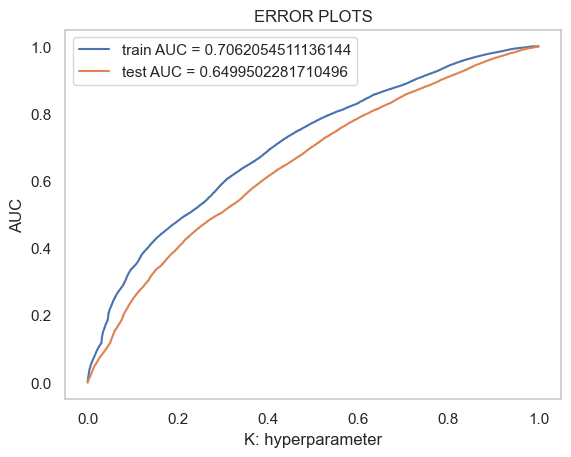

the maximum value of tpr*(1-fpr) 0.41881506033650817 for threshold 0.473
              precision    recall  f1-score   support

           0       0.64      0.67      0.65    127507
           1       0.65      0.63      0.64    127507

    accuracy                           0.65    255014
   macro avg       0.65      0.65      0.65    255014
weighted avg       0.65      0.65      0.65    255014

              precision    recall  f1-score   support

           0       0.72      0.58      0.64     68916
           1       0.48      0.63      0.55     42726

    accuracy                           0.60    111642
   macro avg       0.60      0.61      0.59    111642
weighted avg       0.63      0.60      0.61    111642

Model test F1 score is :  0.5461950434764901
Model test AUC score is :  0.6499502281710496


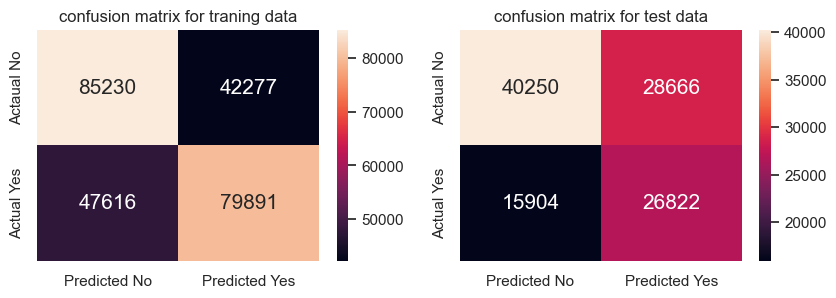

In [211]:
rf_fea_model_f1_score, rf_fea_model_AUC_score = model_performence_check(RF2,X_train1,X_val1,y_train,y_val)

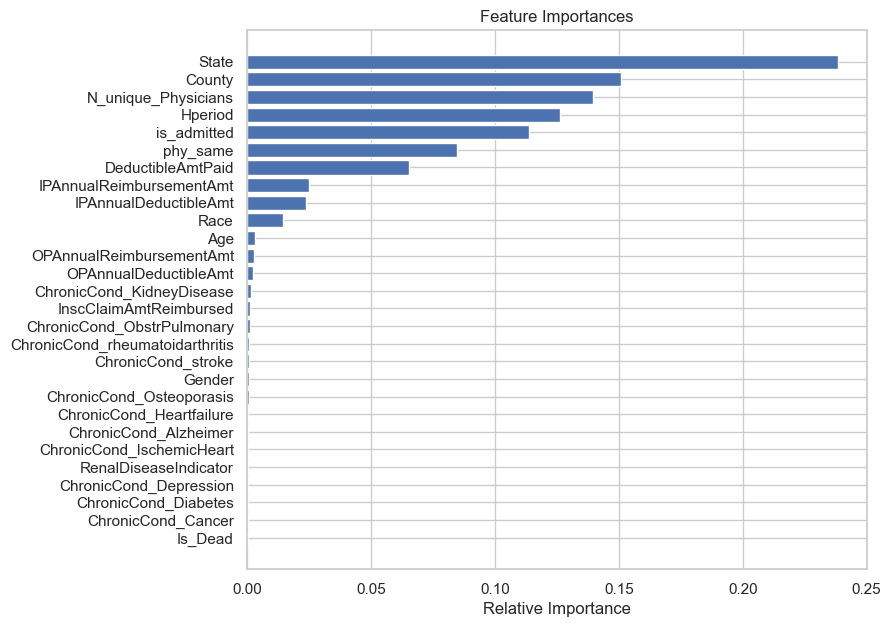

In [212]:
features = X_train1.columns
importances = RF2.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### Model 4: Xg_Boost

In [213]:
XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train1,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 3/5; 2/10] START eta=0.001, n_estimators=50.................................
[CV 3/5; 1/10] START eta=0.3, n_estimators=100..................................
[CV 5/5; 1/10] START eta=0.3, n_estimators=100..................................
[CV 2/5; 2/10] START eta=0.001, n_estimators=50.................................
[CV 1/5; 1/10] START eta=0.3, n_estimators=100..................................
[CV 1/5; 2/10] START eta=0.001, n_estimators=50.................................
[CV 4/5; 1/10] START eta=0.3, n_estimators=100..................................
[CV 2/5; 1/10] START eta=0.3, n_estimators=100..................................
[CV 1/5; 2/10] END eta=0.001, n_estimators=50;, score=(train=0.728, test=0.719) total time=   2.8s
[CV 2/5; 2/10] END eta=0.001, n_estimators=50;, score=(train=0.727, test=0.720) total time=   2.9s
[CV 3/5; 2/10] END eta=0.001, n_estimators=50;, score=(train=0.726, test=0.717) total time=   3.0s
[CV 4/5; 2/10] START eta=0.001, n_estimators=50........

In [218]:
XGB2 = xgb.XGBClassifier(eta=0.3,n_estimators=100,n_jobs=-1)

XGB2=XGB2.fit(X_train1,y_train)

print("score",XGB2.score(X_val1,y_val))

score 0.732322960892854


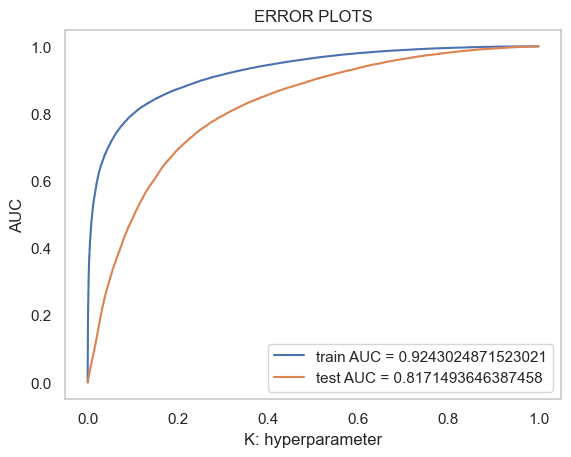

the maximum value of tpr*(1-fpr) 0.7213988945559199 for threshold 0.488
              precision    recall  f1-score   support

           0       0.83      0.88      0.85    127507
           1       0.87      0.82      0.85    127507

    accuracy                           0.85    255014
   macro avg       0.85      0.85      0.85    255014
weighted avg       0.85      0.85      0.85    255014

              precision    recall  f1-score   support

           0       0.85      0.68      0.76     68916
           1       0.61      0.81      0.70     42726

    accuracy                           0.73    111642
   macro avg       0.73      0.74      0.73    111642
weighted avg       0.76      0.73      0.73    111642

Model test F1 score is :  0.6958690819846913
Model test AUC score is :  0.8171493646387458


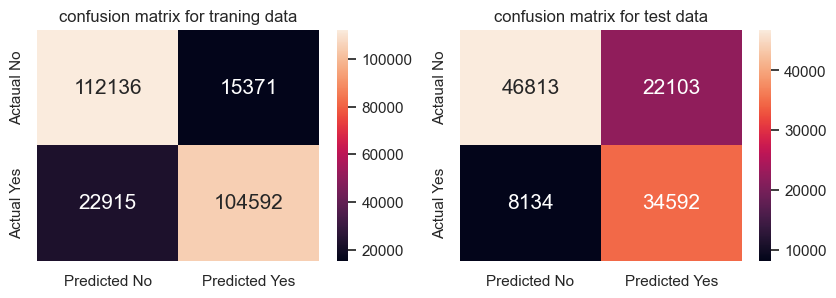

In [219]:
xg_fea_model_f1_score, xg_fea_model_AUC_score = model_performence_check(XGB2,X_train1,X_val1,y_train,y_val)

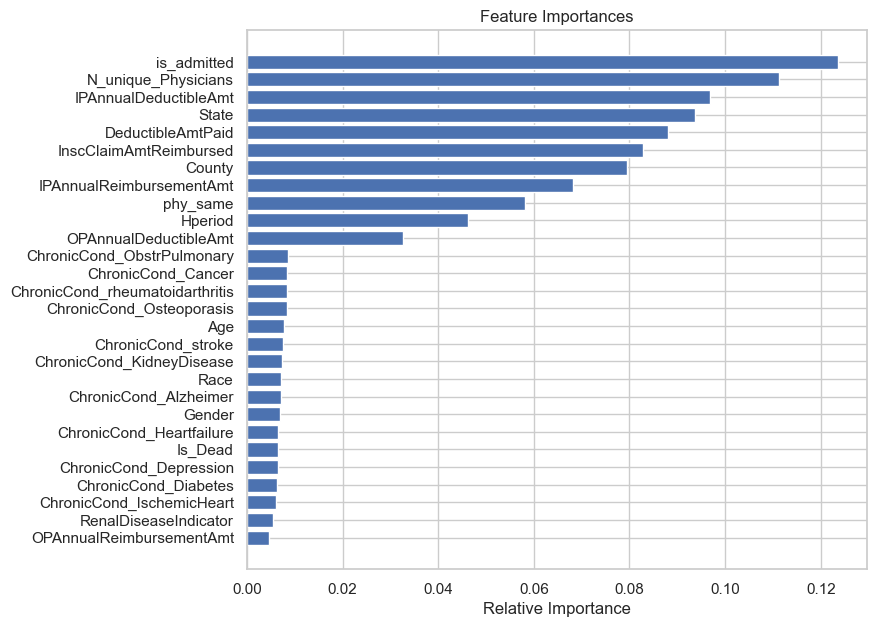

In [220]:
features = X_train1.columns
importances = XGB2.feature_importances_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(8,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

###### plot model performence summary graph


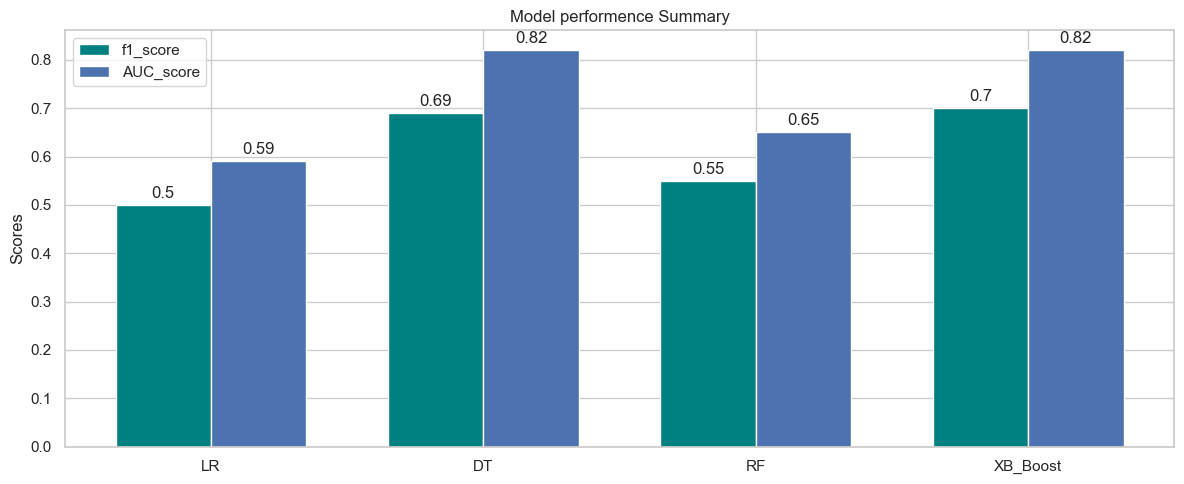

In [221]:
model_imp_fea = ['LR','DT','RF','XB_Boost']
f1_score_imp_fea = [round(num, 2) for num in [lr_fea_model_f1_score,dt_fea_model_f1_score, rf_fea_model_f1_score, xg_fea_model_f1_score]]
AUC_score_imp_fea = [round(num, 2) for num in [lr_fea_model_AUC_score,dt_fea_model_AUC_score,rf_fea_model_AUC_score,xg_fea_model_AUC_score]]
model_comp(model,f1_score_imp_fea,AUC_score_imp_fea,'Scores','Model performence Summary','f1_score','AUC_score')

##### Comparison using all features VS Imp features


In [222]:
model = ['LR','DT','RF','XB_Boost']

model_performence_df = pd.DataFrame()

model_performence_df['Model'] = model
model_performence_df['f1_score'] = f1_score
model_performence_df['f1_score_imp_fea'] =f1_score_imp_fea
model_performence_df['AUC_score'] = AUC_score
model_performence_df['AUC_score_imp_fea'] = AUC_score_imp_fea

model_performence_df

,Model,f1_score,f1_score_imp_fea,AUC_score,AUC_score_imp_fea
0,LR,0.50,0.50,0.59,0.59
1,DT,0.69,0.69,0.82,0.82
2,RF,0.55,0.55,0.65,0.65
3,XB_Boost,0.66,0.70,0.78,0.82


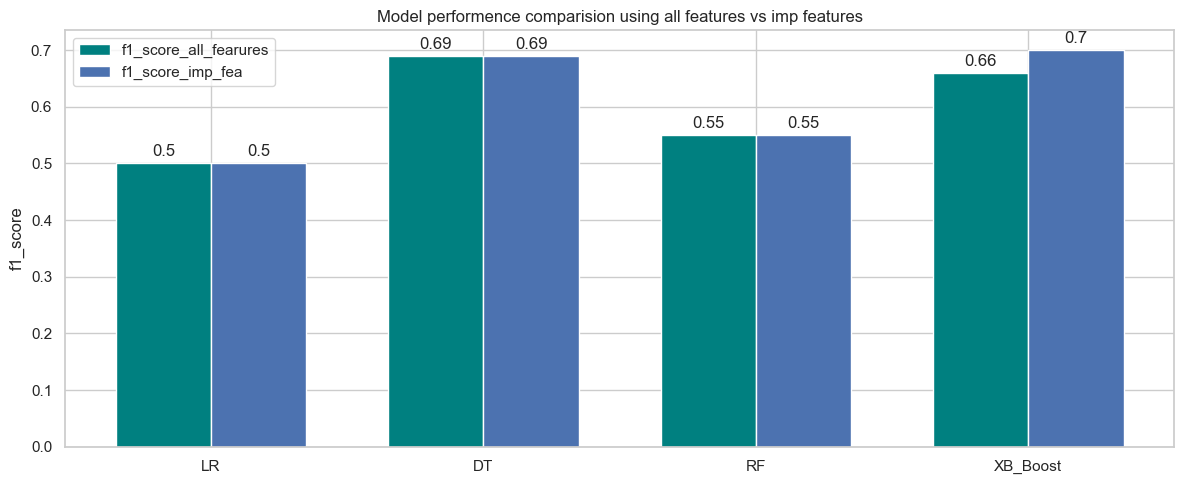

In [223]:
model_comp(model,f1_score,f1_score_imp_fea,'f1_score',
           'Model performence comparision using all features vs imp features',
          'f1_score_all_fearures','f1_score_imp_fea')

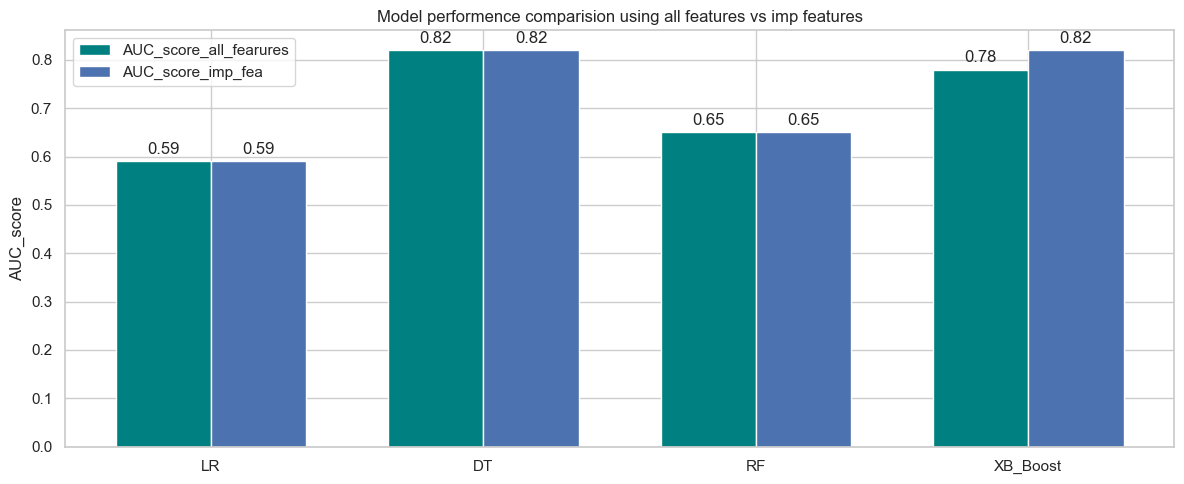

In [224]:
model_comp(model,AUC_score,AUC_score_imp_fea,'AUC_score','Model performence comparision using all features vs imp features',
          'AUC_score_all_fearures','AUC_score_imp_fea')

##### Conclusion
There is not a significant difference in model performance between using all features and using selected features. However, we do observe slightly better performance in some models when using all features.